In [1]:
from noise import generate_noise_realization
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datageneration.datageneration.waveforms import *
from datageneration.datageneration.distributions import *
from datageneration.datageneration.population_model import *
from utils import get_rfft
import os, sys
from importlib import reload
reload(sys.modules["datageneration.datageneration.waveforms"])
reload(sys.modules["datageneration.datageneration.distributions"])
reload(sys.modules["datageneration.datageneration.population_model"])
reload(sys.modules["utils"])
from datageneration.datageneration.waveforms import *
from datageneration.datageneration.distributions import *
from datageneration.datageneration.population_model import *
from utils import get_rfft
from tqdm import tqdm

/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


# Generate realistic LISA noise

In [2]:
dt_noise = 4
dur_noise = int(5e5)

In [3]:
noise_dict = generate_noise_realization(dt_noise, # dt (in s)
                                        dur_noise
#                                         30*24*3600 # Tobs (in s)
                                       )

/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/home/alexander/miniconda3/envs/lisa-pop-env-1/lib/python3.12/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply


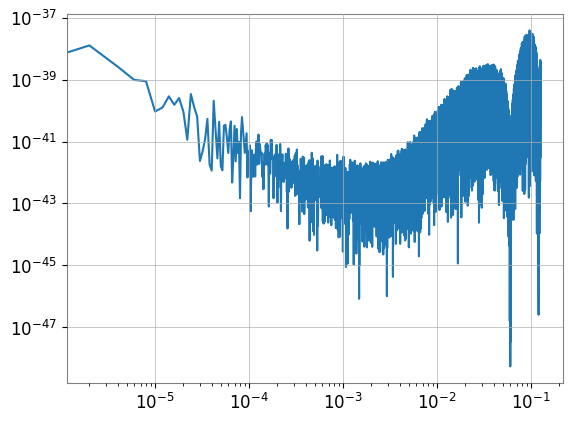

In [4]:
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0])

In [5]:
# note that noise timeseries for A,E,T channels is here:
noise_dict["timeseries"],noise_dict['ts']

(array([[ 9.38437150e-21, -1.23884161e-20,  4.04437956e-21, ...,
          1.99388418e-20, -6.37180685e-21,  7.84722449e-23],
        [-2.25944132e-20,  2.25462626e-20, -9.24163553e-21, ...,
         -1.47022687e-20, -1.02805918e-21,  1.27923099e-20],
        [ 8.06468792e-21,  3.71797191e-21, -4.96216113e-21, ...,
         -1.32965554e-22, -1.84052181e-21, -5.58712007e-21]],
       shape=(3, 125000)),
 array([0.000000e+00, 4.000032e+00, 8.000064e+00, ...,
        4.999920e+05, 4.999960e+05, 5.000000e+05],
       shape=(125000,)))

In [6]:
def quick_mc(m1,m2):
    return (m1*m2)**(3/5)/(m1+m2)**(1/5)

In [7]:
quick_mc(0.17,0.17),quick_mc(1.3,1.3)

(0.14799359576034113, 1.1317157322849616)

# Generate the population

In [8]:
limits = {'chirp_mass':          [0.5, 1.1],  # In solar masses
#           'seperation':          [0.5, 25.0],   # In 1e8 meters
          'seperation':          [5.0, 10.0],   # In 1e8 meters
          'luminosity_distance': [1.0, 50.0],     # In kilo parsecs
          'phase':               [0, 2*np.pi]}
## Instantiate the population distribution object
N_dwd = 1500
dist = PowerLawChirpPowerLawSeperation(limits=limits, 
                                       distance_power_law_index=1,   # p(d) ~ d
                                       N_white_dwarfs=N_dwd,
                                       duration = dur_noise,
                                       sample_rate = 1/dt_noise,
                                       poisson=False) 			     # Total Number of sources should be drawn from poisson distribution

Lambda = {'alpha' : 4.0, 'beta' : -2.0}
# popdict = dist.waveform.compute_waveform_parameters(dist.generate_samples(Lambda, size=N_dwd))
poptimes, popstrains = dist.generate_time_series(Lambda,summed=False)
popdict = dist.samples_from_population
popstrains_original = popstrains

Generating waveforms...


In [9]:
popstrains.shape,len(popdict['amplitude'])

((125000, 1500), 1500)

In [10]:
df = pd.DataFrame(popdict)

In [274]:
## hacky but works for the toy model
## setting arbitrary (flat) response functions
R_LISA = 1e-4 #3/20 #5e-3
popstrains = np.sqrt(R_LISA)*popstrains_original

In [275]:
dist.N_white_dwarfs

1500

In [276]:
df.keys()

Index(['amplitude', 'frequency', 'phase', 'chirp_mass', 'seperation',
       'luminosity_distance'],
      dtype='object')

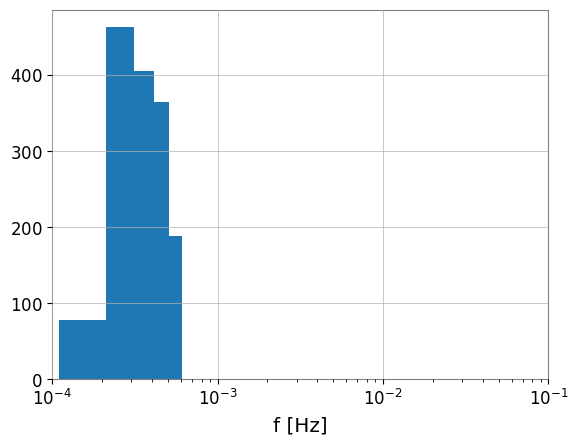

In [277]:
## look at the frequency dists
plt.figure()
plt.hist(df['frequency'],bins=np.linspace(10**-5,10**-1,1000))
plt.xscale('log')
plt.xlim(1e-4,1e-1)
plt.xlabel("f [Hz]")
plt.show()

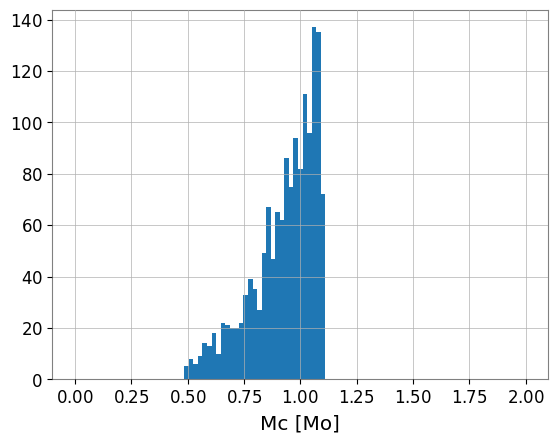

In [278]:
## look at the frequency dists
plt.figure()
plt.hist(df['chirp_mass'],bins=np.linspace(0,2,100))
# plt.xscale('log')
# plt.xlim(1e-4,1e-1)
plt.xlabel("Mc [Mo]")
plt.show()

In [279]:
# dt = poptimes[1] - poptimes[0]
dt = dt_noise

In [280]:

# possible bug here in frequencies when vectorized
popfreq, popstrainsfft = get_rfft(popstrains.T, poptimes, 1/dt_noise)
popfreq = np.fft.rfftfreq(len(poptimes),dt_noise)[1:]

In [281]:
popstrainsfft.shape

(1500, 62500)

In [282]:
# noise timeseries is calibrated so that scipy.signal.welch gives correct amplitude

In [283]:
fw, popwelch = scipy.signal.welch(np.sum(popstrains.T,axis=0),fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)

In [284]:
## full time series
times_full = poptimes
hoft_full = np.sum(popstrains.T,axis=0) + noise_dict["timeseries"][0]
fs_full, fullwelch = scipy.signal.welch(hoft_full,fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)

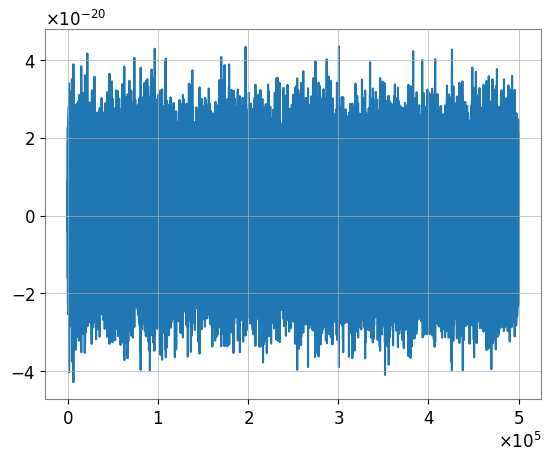

In [285]:
plt.figure()
plt.plot(times_full,hoft_full)
plt.show()

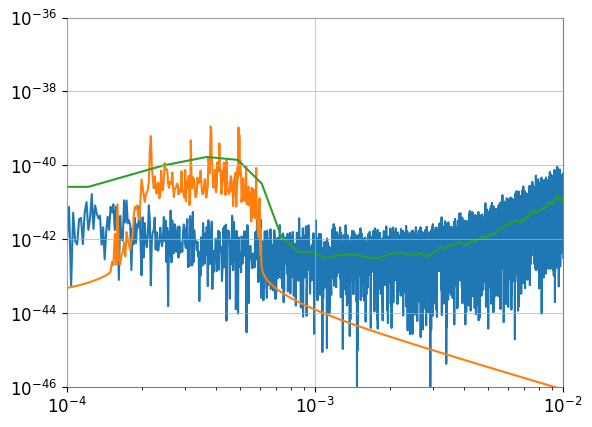

In [286]:
plt.figure()
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0])
plt.loglog(popfreq,np.sum(np.abs(popstrainsfft)**2/poptimes[-1],axis=0))
plt.loglog(fs_full,fullwelch)
plt.xlim(1e-4,1e-2)
plt.ylim(1e-46,1e-36)
plt.show()

In [287]:
popstrains.shape

(125000, 1500)

In [288]:
popstrainsfft.shape

(1500, 62500)

In [289]:
## some checks on our assumptions
## 1: fft of sum of timeseries vs sum of ffts
sumfreqs, summed_fft = get_rfft(np.sum(popstrains.T,axis=0),poptimes,1/dt_noise)
summed_fft_psd = np.abs(summed_fft)**2/poptimes[-1]

In [290]:
sumfreqs.min(),sumfreqs.max()

(Array(2.e-06, dtype=float32), Array(0.125, dtype=float32))

In [291]:
sumfreqs[1]-sumfreqs[0],1/dur_noise

(Array(2.e-06, dtype=float32), 2e-06)

In [292]:
## 2: sum of individual binary PSDs
fs_fullres = sumfreqs
f_idx = np.digitize(df['frequency'].to_numpy(),fs_fullres+0.5*(1/dur_noise))
hsum_psd = np.zeros(len(fs_fullres))
for i in range(np.max(f_idx) + 1):
    fbin_mask = np.array(f_idx == i)
    if np.sum(fbin_mask) == 0:
        continue
    else:
        fbin_psd = dur_noise*np.sum(df['amplitude'].to_numpy()[fbin_mask]**2) ## missing factor of dur_noise
        hsum_psd[i] += fbin_psd
    

/tmp/ipykernel_5903/3478478808.py:3: RuntimeWarning: divide by zero encountered in log10
  diff = np.log10(np.abs(R_LISA*hsum_psd/summed_fft_psd))


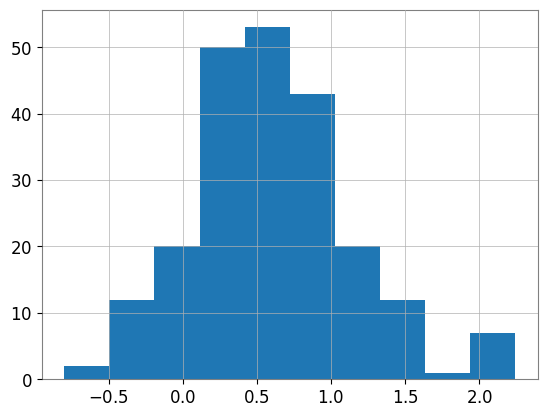

In [293]:
plt.figure()
# plt.plot(fs_fullres,np.log10(np.abs(hsum_psd/summed_fft_psd)))
diff = np.log10(np.abs(R_LISA*hsum_psd/summed_fft_psd))
plt.hist(diff[np.invert(np.isinf(diff))])
# plt.xscale('log')
plt.show()

In [294]:
## now try correct formalism but bin at

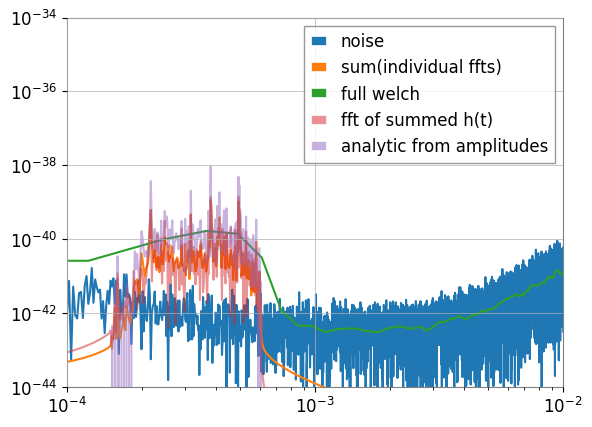

In [295]:
plt.figure()
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0],label='noise')
plt.loglog(popfreq,np.sum(np.abs(popstrainsfft)**2/poptimes[-1],axis=0),label='sum(individual ffts)')
plt.loglog(fs_full,fullwelch,label='full welch')
plt.loglog(sumfreqs,summed_fft_psd,alpha=0.5,label='fft of summed h(t)')
plt.loglog(fs_fullres,R_LISA*hsum_psd,alpha=0.5,label='analytic from amplitudes')
plt.xlim(1e-4,1e-2)
plt.ylim(1e-44,1e-34)
plt.legend()
plt.show()

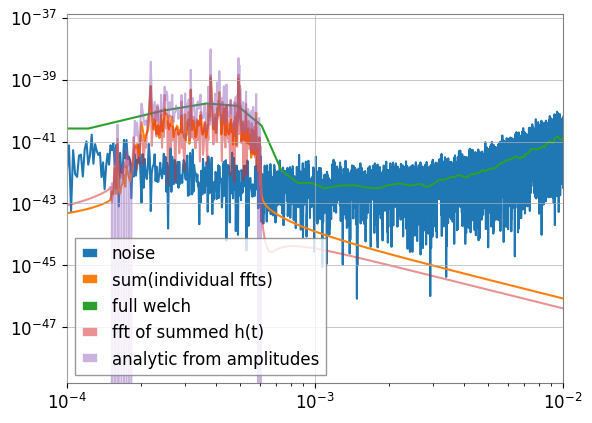

In [296]:
plt.figure()
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0],label='noise')
plt.loglog(popfreq,np.sum(np.abs(popstrainsfft)**2/poptimes[-1],axis=0),label='sum(individual ffts)')
plt.loglog(fs_full,fullwelch,label='full welch')
plt.loglog(sumfreqs,summed_fft_psd,alpha=0.5,label='fft of summed h(t)')
plt.loglog(fs_fullres,R_LISA*hsum_psd,alpha=0.5,label='analytic from amplitudes')
plt.xlim(1e-4,1e-2)
# plt.ylim(1e-39,1e-35)
plt.legend()
plt.show()

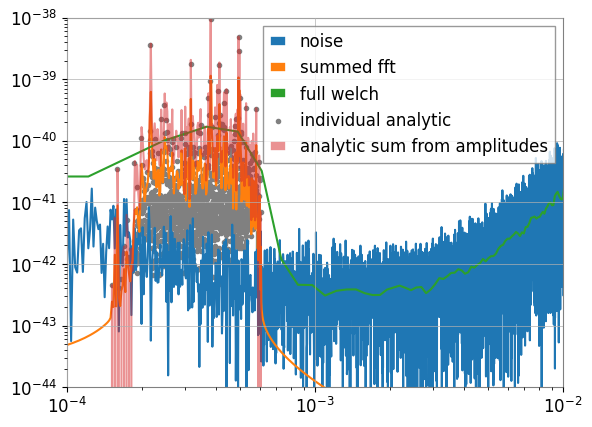

In [297]:
plt.figure()
plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0],label='noise')
plt.loglog(popfreq,np.sum(np.abs(popstrainsfft)**2/poptimes[-1],axis=0),label='summed fft')
plt.loglog(fs_full,fullwelch,label='full welch')
plt.scatter(df['frequency'],R_LISA*dur_noise*df['amplitude']**2,marker='.',c='grey',label='individual analytic')
plt.loglog(fs_fullres,R_LISA*hsum_psd,alpha=0.5,label='analytic sum from amplitudes')
# plt.loglog(sumfreqs,summed_fft_psd,alpha=0.5)
# plt.loglog(fs_fullres,4*hsum_psd,alpha=0.5)
plt.xlim(1e-4,1e-2)
plt.ylim(1e-44,1e-38)
plt.legend()
plt.show()

In [298]:
(df['amplitude']**2).shape

(1500,)

In [299]:
np.max(np.abs(popstrainsfft[0,:])**2/poptimes[-1]),4*df['amplitude'][0]**2


(np.float64(2.63012847677685e-43), np.float64(8.467335393214754e-44))

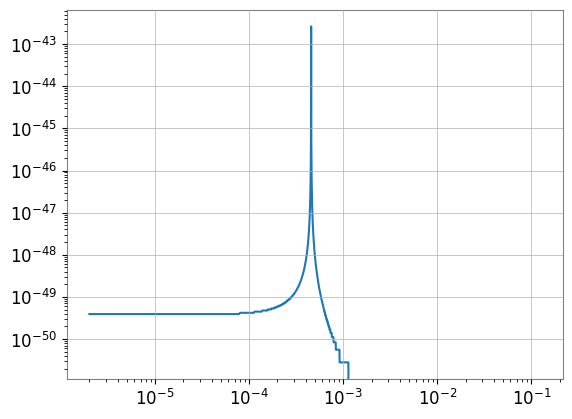

In [300]:
plt.loglog(popfreq,np.abs(popstrainsfft[0,:])**2/poptimes[-1])

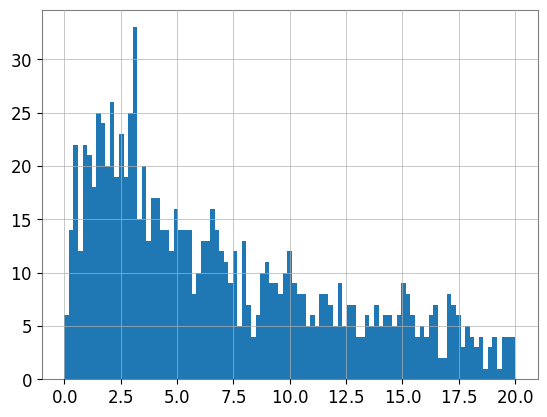

In [301]:
close_f_idx = [np.argmin(np.abs(noise_dict['freqs'] - df['frequency'][i])) for i in range(len(df))]
plt.hist(R_LISA*dur_noise*df['amplitude']**2/np.array(noise_dict['PSD'][0][close_f_idx]),bins=np.linspace(0,20,100))
plt.show()

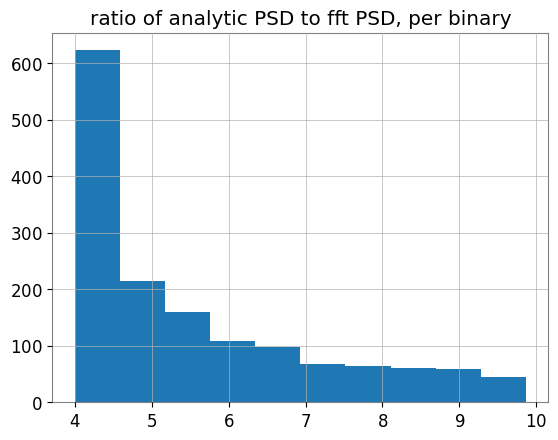

In [302]:
plt.figure()
plt.hist(R_LISA*dur_noise*df['amplitude']**2/(np.max(np.abs(popstrainsfft)**2/poptimes[-1],axis=1)))
plt.title('ratio of analytic PSD to fft PSD, per binary')
plt.show()

# Iterative subtraction method

In [303]:
# need to implement this, basically:
# add noise timeseries + WDs
# compute welched PSD, subtract WDs that exceed SNR (to current noise+signals PSD of your threshold (typically 7))
# repeat above step at least 15-ish times

def run_iterative_subtraction(times,hoft_full,popstrains,R,N_iter=15):
    '''
    Function to perform iterative DWD subtraction by leave-one-out noise+population SNR
    
    Arguments
    ----------------------
    times (float array) : Array of the times at which hoft_full is sampled
    hoft_full (float array) : The full strain time-series (noise + all signals)
    df (dataframe)           : Dataframe containing the DWD population information
    popstrains (float array) : The N_dwd x time array of each binary's strain time-series
    
    Returns
    -----------------------
    res_idx (array)   : Current indices of the DWD df containing resolved systems.
    unres_idx (array) : Current indices of the DWD df containing unresolved systems.
    res_snrs (array)  : Final SNRs of all DWDs.
    
    '''
    ## get welched PSD approx
    dt = times[1] - times[0]
    fs_full, fullwelch = scipy.signal.welch(hoft_full,fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)
    
    ## bin the binaries by frequency
    ## such that the center of each bin is one of our fft frequencies
    delf = fs_full[1] - fs_full[0]
    sorted_f_idx = np.digitize(np.array(df['frequency']),fs_full+0.5*delf)
    
    ## initialize the starting quantities
    current_hoft_full = hoft_full
    current_unres_idx = np.arange(popstrains.shape[1],dtype=int)
    current_res_idx = np.array([],dtype=int)
    resolved_snrs = np.array([],dtype=float)
    prev_N = 0

    for i in range(N_iter):
        ## make an array of fs x N_dwd
        ## where for each binary we have the fft of the time series without that binary
        ## only including systems we haven't yet resolved
        fs_i, current_welch_loo = scipy.signal.welch(current_hoft_full - popstrains[:,current_unres_idx].T,
                                                   fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)
        current_latf = np.array([current_welch_loo[ii,fidx] for ii,fidx in enumerate(sorted_f_idx[current_unres_idx])])
        ## snrs for circular, monochromatic binaries
        current_snrs = np.sqrt(dur_noise*R*np.array(df['amplitude'])[current_unres_idx]**2 / (current_latf))

        ## update
        current_resolved_filt = current_snrs >= 7
        current_res_idx = np.append(current_res_idx,current_unres_idx[current_resolved_filt])
        resolved_snrs = np.append(resolved_snrs,current_snrs[current_resolved_filt])
        current_N = len(current_res_idx)
        print("N resolved: {}".format(current_N))
        current_hoft_full = current_hoft_full - np.sum(popstrains[:,current_unres_idx[current_resolved_filt]],axis=1)
        current_unres_idx = current_unres_idx[np.invert(current_resolved_filt)]
        
        if current_N == prev_N:
            print("Iterative subtraction has converged, stopping after {} iterations.".format(i+1))
            break
        else:
            prev_N = current_N
    
    frac_res = len(current_res_idx)/popstrains.shape[1]
    print("Final number of resolved binaries is {}. This is {:0.2f}% of the total catalogue.".format(current_N,frac_res))
    
    resolved_idx, unresolved_idx, unresolved_snrs = current_res_idx, current_unres_idx, current_snrs
    return resolved_idx, unresolved_idx, resolved_snrs, unresolved_snrs

    

In [304]:
res_idx, unres_idx, res_snrs, unres_snrs = run_iterative_subtraction(times_full,hoft_full,popstrains,R_LISA,N_iter=15)

N resolved: 1
N resolved: 3
N resolved: 3
Iterative subtraction has converged, stopping after 3 iterations.
Final number of resolved binaries is 3. This is 0.00% of the total catalogue.


In [305]:
unres_snrs

array([0.10468201, 0.20695638, 0.26334019, ..., 0.30266847,
       0.58005313, 0.15777144], shape=(1497,))

In [306]:
np.max(unres_snrs)

np.float64(5.8545603444412135)

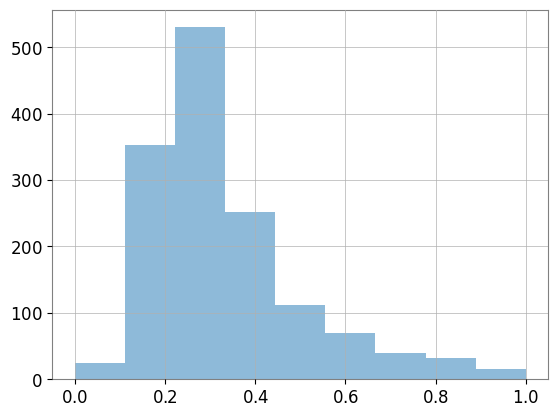

In [307]:
plotmax = 1
plt.figure()
plt.hist(unres_snrs,bins=np.linspace(0,plotmax,10),alpha=0.5)
# plt.hist(res_snrs,bins=np.linspace(0,plotmax,plotmax),alpha=0.5)
plt.show()

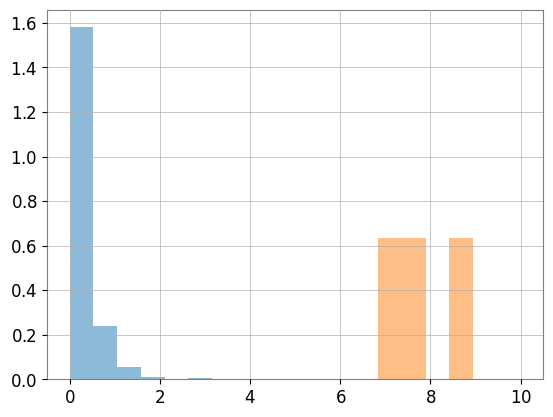

In [308]:
plotmax = 10
plt.figure()
plt.hist(unres_snrs,bins=np.linspace(0,plotmax,2*plotmax),alpha=0.5,density=True)
plt.hist(res_snrs,bins=np.linspace(0,plotmax,2*plotmax),alpha=0.5,density=True)
plt.show()

In [309]:
## get a welched noise PSD
noft_A = noise_dict["timeseries"][0,:]
dtn = noise_dict['ts'][1] - noise_dict['ts'][0]

fw_noise, welch_noise_psd = scipy.signal.welch(noft_A,fs=1/dtn,window='hann',noverlap=0.0,nperseg=256*8)

In [310]:
## get info for plotting the resolved and unresolvd binaries
fw_unresolved, welch_unresolved = scipy.signal.welch(np.sum(popstrains[:,unres_idx],axis=1),
                                               fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)

# psds_resolved1 = R_LISA*np.array(df['amplitude'][current_res_idx])**2
# psds_resolved = np.sum(np.abs(popstrainsfft[current_res_idx])**2/poptimes[-1],axis=0)#*(popfreq[1]-popfreq[0])

In [312]:
fs_resolved = np.array(df['frequency'][res_idx])
# psds_resolved = 0.5*R_LISA*(fw_unresolved[1]-fw_unresolved[0])**-1 *np.array(df['amplitude'][res_idx])**2
psds_resolved = R_LISA*dur_noise*np.array(df['amplitude'][res_idx])**2

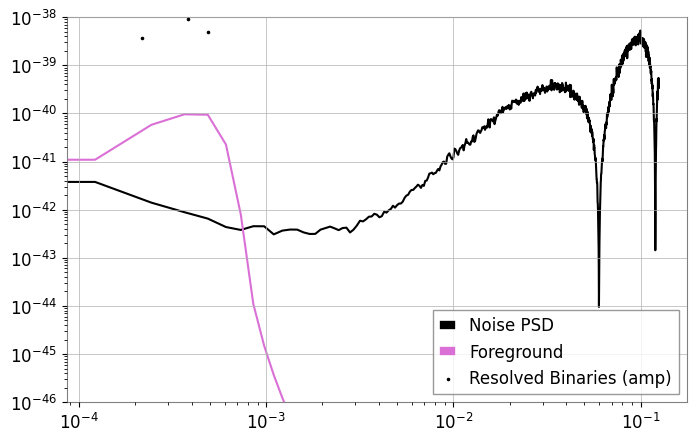

In [314]:
plt.figure(figsize=(8,5))
# plt.loglog(noise_dict['freqs'],noise_dict['PSD'][0],c='slategrey',label='Noise PSD')
plt.loglog(fw_noise, welch_noise_psd,c='k',label='Noise PSD')
plt.loglog(fw_unresolved,welch_unresolved,c='orchid',label='Foreground')
# plt.loglog(popfreq,psds_resolved,c='maroon',label='Resolved Binaries (fft)')
plt.scatter(fs_resolved,psds_resolved,marker='.',s=10,c='k',label='Resolved Binaries (amp)',zorder=10)
# plt.scatter(fs_resolved,psds_resolved,marker='*',s=10,c='maroon',label='Resolved Binaries (fft)')
plt.ylim(1e-46,1e-38)
plt.legend()#loc='upper left')
plt.show()

# New method -- does it give the same answer?

In [30]:
# see notes / code in foreground.py
# try it with same population and make sure the answer is identical / equivalent to iterative subtraction

This is maybe simpler than I was expecting, b/c for the fiducial population, all $w_{ij} = 1$. So all we need to do is:
 - sort by frequency bin
 - therein, sort by naive (i.e., noise-only) SNR
 - for all binaries, compute the SNR from noise + sum of all lower-amplitude binaries in that bin (with, e.g., np.cumsum)
 - $f_{res}$ will then be $\sum_i\sum_{j\ge k_i}(1) = \sum_i (N_i - k_i)$, where $N_i$ is the number of binaries in bin $i$
 - and the foregound amplitude will be the sum of the strain PSDs of all binaries in bin $i$ with $j\le k_i$

In [357]:
np.cumsum(np.array([1,2,3,4]))-np.array([1,2,3,4]),np.cumsum(np.array([1,2,3,4]))

(array([0, 1, 3, 6]), array([ 1,  3,  6, 10]))

In [359]:
## from foreground.py
def calc_Nij(A, noisePSD, wts, duration):
    '''
    Make the per-frequency SNR vector (dim 1xN_dwd)
    
    Arguments
    ------------
    A (float array)      : Sorted (ascending) DWD amplitudes
    noisePSD (float)     : Level of the noise PSD in the relevant frequency bin (i.e., S_n(f))
    wts (float or array) : weights from fiducial population (1 for now)
    '''
#     np.sqrt(dur_noise*np.array(df['amplitude'])[current_unres_idx]**2 / (4*current_latf))
    return np.sqrt(duration*A**2/((noisePSD + duration * (np.cumsum(wts*A**2) - wts*A**2) )))
#     return A / (noisePSD + np.cumsum(wts*A))

In [360]:
def bin_sort_threshold(binaries,fs_full,fs_noise,noisePSD,duration,LISA_rx,wts=1,snr_thresh=7):
    '''
    Function to bin by frequency, then for the vector of binaries in each frequency bin, sort them by amplitude.
    
    Arguments
    -----------
    binaries (dataframe) : df with binary info. Will rephrase arguments in terms of the specific needed components later.
    fs_full (float array) : data frequencies
    noisePSD  (float)     : Level of the noise PSD in the relevant frequency bin (i.e., S_n(f))
    LISA_rx (float or array) : (pseudo) LISA response function (currently just a numerical factor)
    wts (float or array) : weights from fiducial population (1 for now)
    snr_thresh (float)    : the SNR threshold to condition resolved vs. unresolved on
    
    Returns
    -----------
    foreground_amp (array) : Stochastic foreground from unresolved sources, evaluated at fs_full.
    N_res (int)            : Number of resolved DWDs
    res_idx (array)        : Indices of the binaries dataframe for resolved DWDs.
    unres_idx (array)      : Indices of the binaries dataframe for unresolved DWDs.
    '''
    dwd_fs = np.array(binaries['frequency'])
    dwd_amps = np.array(binaries['amplitude'])
    dwd_idx = np.arange(len(binaries['amplitude']))
    
    ## constrain to frequencies where we have a noise curve
    if fs_noise[0] == 0:
        fs_noise = fs_noise[1:]
        noisePSD = noisePSD[1:]
    noise_f_mask = (fs_full>=fs_noise.min()) & (fs_full<=fs_noise.max())
    fs_full = fs_full[noise_f_mask]
    ## find which noise frequency corresponds to each frequency bin
    noise_f_idx = np.digitize(fs_full,fs_noise-(fs_noise[1]-fs_noise[0])/2)
    
    ## bin the binaries by frequency
    ## first, find which frequency bin each binary is in
    delf = fs_full[1] - fs_full[0]
    f_idx = np.digitize(dwd_fs,fs_full+0.5*delf)
    
    
    
    ## now created a ragged list of arrays of varying sizes, corresponding to N_dwd(f_i)
    ## each entry is an array containing the indices of the DWDs in that bin, sorted by ascending amplitude*
    ##     * under the current assumption of uniform responses, this is equivalent to sorting by the naive SNR
    ##       (!! -- we will need to refine this in future)
    fbin_res_list = []
    foreground_amp = np.zeros(len(fs_full))
    
    for i in range(np.max(f_idx)+1):
        fbin_mask_i = np.array(f_idx == i)
        fbin_amps_i = dwd_amps[fbin_mask_i]*np.sqrt(LISA_rx) ## sqrt because we square the amplitudes to get Sgw
        fbin_sort_i = np.argsort(fbin_amps_i)
        re_sort_i = np.argsort(fbin_sort_i) ## this will allow us to later return to the original order
        
        fbin_Nij = calc_Nij(fbin_amps_i[fbin_sort_i],noisePSD[noise_f_idx[i]],wts,duration)
        if fbin_Nij.size > 0:
            print(np.max(fbin_Nij))
        res_mask_i = fbin_Nij>=snr_thresh
        res_mask_i_resort = res_mask_i[re_sort_i]
        fbin_res_list.append(dwd_idx[fbin_mask_i][res_mask_i_resort])
        
        foreground_amp[i] = np.sum(fbin_amps_i[np.invert(res_mask_i_resort)]**2)

    ##unpack the binned list
    res_idx = np.array([],dtype=int)
    for i, arr in enumerate(fbin_res_list):
        res_idx = np.append(res_idx,arr)
    N_res = len(res_idx)
    unres_idx = np.isin(dwd_idx,res_idx,invert=True)
    
    return foreground_amp, fs_full, N_res, res_idx, unres_idx
        
        
        

In [361]:
fg_fast, fg_fs, N_res_fast, res_idx_fast, unres_idx_fast = bin_sort_threshold(df,fs_fullres,
                                                                       fw_noise,welch_noise_psd,dur_noise,
                                                                       R_LISA,wts=1,snr_thresh=7)

0.5696619926831605
1.9991650576045898
5.0053602995032485
0.5383588165668873
0.6327000842317863
1.0307362714518449
1.1748821569216856
1.4841553441558295
0.9192444218874184
0.8720626059973973
1.1260356496208566
0.9320960251803493
1.1186337162370636
3.371883730446003
1.1413879530910884
1.018618317988314
1.090602564219655
2.928234356822704
1.282586887056657
1.8922014610668385
1.0846835079082504
1.843470179087686
1.6545707723173189
2.0206384529344157
1.709316668337875
1.785683622448235
4.612734882045668
1.7988673125846375
4.924752244017315
1.100862156122775
1.5033601150238713
1.9634517445658357
1.0941653897764094
1.6052025623239243
1.7466363021575289
1.1384845399648176
2.373323204365888
0.986780860488476
1.2778984544767304
1.637826536267675
2.7172285935260247
1.213740227464977
1.1610252468606943
2.1038316258519547
1.4525874231845453
1.4887357193250454
1.5236398812454581
1.3934228827888744
1.892920701089849
1.0496221570590543
1.5050646452364158
1.5701023567000494
2.454629154555866
2.42190416

In [362]:
N_res_fast

6

In [363]:
## make a welched foreground to check amplitudes
fw_unresolved_fast, welch_unresolved_fast = scipy.signal.welch(np.sum(popstrains[:,unres_idx_fast],axis=1),
                                               fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)

In [369]:
np.max(fg_fast)

np.float64(7.533082979305545e-45)

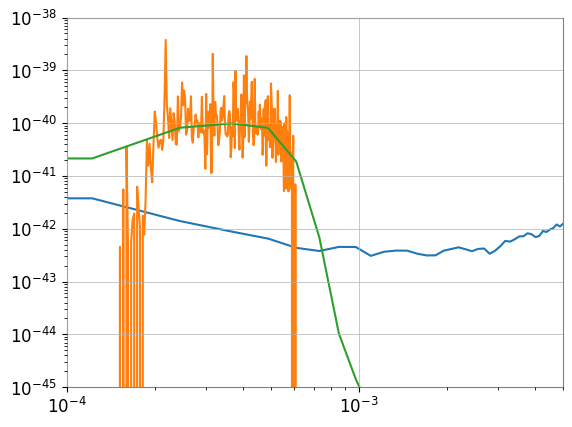

In [364]:
plt.figure()
plt.loglog(fw_noise,welch_noise_psd)
plt.loglog(fg_fs,dur_noise*fg_fast)
plt.loglog(fw_unresolved_fast,welch_unresolved_fast)
plt.xlim(1e-4,5e-3)
plt.ylim(1e-45,1e-38)
plt.show()

In [365]:
fs_resolved_fast = np.array(df['frequency'][res_idx_fast])
psds_resolved_fast = R_LISA*dur_noise*np.array(df['amplitude'][res_idx_fast])**2

In [38]:
# figpath = './figures/R5e-4/'
# if not os.path.exists(figpath):
#     os.mkdir(figpath)

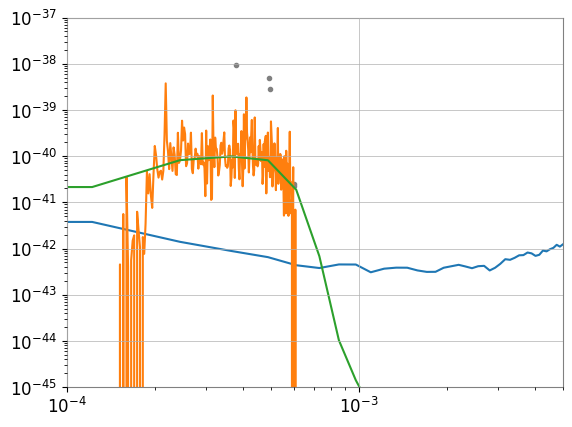

In [368]:
plt.figure()
plt.loglog(fw_noise,welch_noise_psd)
plt.loglog(fg_fs,dur_noise*fg_fast)
plt.loglog(fw_unresolved_fast,welch_unresolved_fast)
plt.scatter(fs_resolved_fast,psds_resolved_fast,c='grey',marker='.')
plt.xlim(1e-4,5e-3)
plt.ylim(1e-45,1e-37)
plt.show()

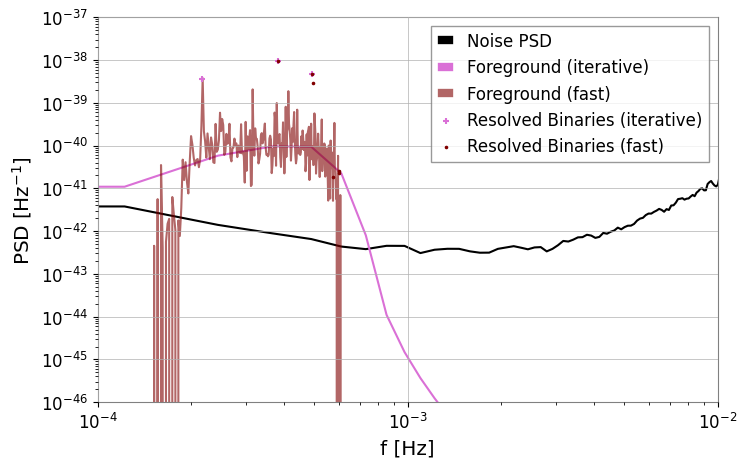

In [375]:
plt.figure(figsize=(8,5))
plt.loglog(fw_noise, welch_noise_psd,c='k',label='Noise PSD')
plt.loglog(fw_unresolved,welch_unresolved,c='orchid',label='Foreground (iterative)')
# plt.loglog(fw_unresolved_fast,welch_unresolved_fast,c='maroon',ls='--',label='Foreground (fast)')
plt.loglog(fg_fs,dur_noise*fg_fast,c='maroon',ls='-',label='Foreground (fast)',alpha=0.6)
plt.scatter(fs_resolved,psds_resolved,marker='+',s=20,c='orchid',label='Resolved Binaries (iterative)',zorder=10)
plt.scatter(fs_resolved_fast,psds_resolved_fast,marker='.',s=10,c='maroon',label='Resolved Binaries (fast)',zorder=10)
plt.ylim(1e-46,1e-37)
plt.xlim(1e-4,1e-2)
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz$^{-1}$]')
plt.legend()#loc='lower right')
# for ext in ['.png','.pdf']:
#     plt.savefig(figpath+'fast_v_iter_psd'+ext)
plt.show()

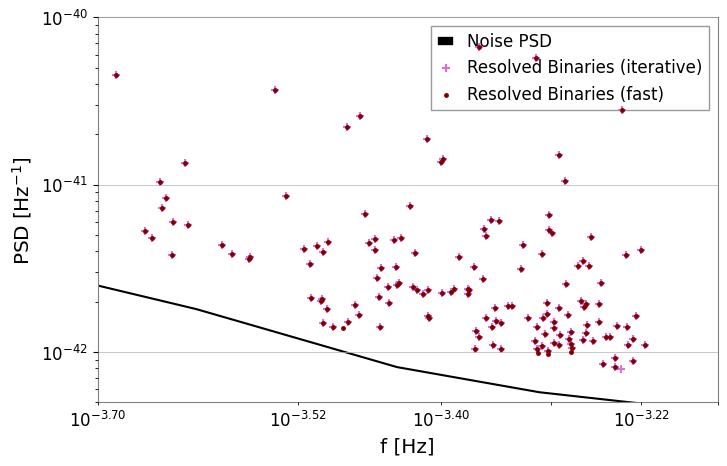

In [40]:
## zoom zoom
plt.figure(figsize=(8,5))
plt.loglog(fw_noise, welch_noise_psd,c='k',label='Noise PSD')
# plt.loglog(fw_unresolved,welch_unresolved,c='orchid',label='Foreground (iterative)')
# plt.loglog(fw_unresolved_fast,welch_unresolved_fast,c='maroon',ls='--',label='Foreground (fast)')
plt.scatter(fs_resolved,psds_resolved,marker='+',s=40,c='orchid',label='Resolved Binaries (iterative)',zorder=10)
plt.scatter(fs_resolved_fast,psds_resolved_fast,marker='.',s=25,c='maroon',label='Resolved Binaries (fast)',zorder=10)
plt.ylim(5e-43,1e-40)
plt.xlim(2e-4,7e-4)
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz$^{-1}$]')
plt.legend()#loc='lower right')
plt.show()

In [41]:
## the island of misfit binaries
matched_idx = np.unique(np.append(res_idx,res_idx_fast))
iter_only = matched_idx[np.isin(matched_idx,res_idx_fast,invert=True)]
fast_only = matched_idx[np.isin(matched_idx,res_idx,invert=True)]

In [42]:
len(matched_idx), len(iter_only), len(fast_only)

(151, 1, 4)

Okay, great. So we have 5 systems that the fast approach is picking up which the iterative approach does not, but that only goes one way; the fast approach does find all systems that get picked up by the iterative approach.

What do these systems look like?

In [43]:
fs_resolved_mismatch = fs_resolved_fast[np.isin(res_idx_fast,res_idx,invert=True)]
psds_resolved_mismatch = psds_resolved_fast[np.isin(res_idx_fast,res_idx,invert=True)]
fs_resolved_match = fs_resolved_fast[np.isin(res_idx_fast,res_idx,invert=False)]
psds_resolved_match = psds_resolved_fast[np.isin(res_idx_fast,res_idx,invert=False)]

In [44]:
fs_unresolved_fast = np.array(df['frequency'][unres_idx_fast])
psds_unresolved_fast = 0.5*R_LISA*(fw_unresolved_fast[1]-fw_unresolved_fast[0])**-1 *np.array(df['amplitude'][unres_idx_fast])**2

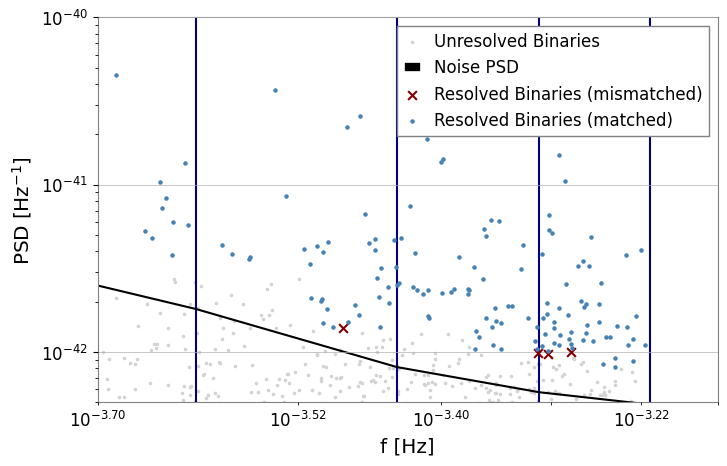

In [45]:
plt.figure(figsize=(8,5))
deltaf = fw_noise[1]-fw_noise[0]
for i in range(len(fw_noise)):
    plt.axvline(fw_noise[i]+deltaf,c='navy',label='__nolabel__')
## add all the unresolved systems
plt.scatter(fs_unresolved_fast,psds_unresolved_fast,
            marker='.',s=10,c='lightgrey',label='Unresolved Binaries')#),zorder=10)
plt.loglog(fw_noise, welch_noise_psd,c='k',label='Noise PSD')
# plt.loglog(fw_unresolved,welch_unresolved,c='orchid',label='Foreground (iterative)')
# plt.loglog(fw_unresolved_fast,welch_unresolved_fast,c='maroon',ls='--',label='Foreground (fast)')
plt.scatter(fs_resolved_mismatch,psds_resolved_mismatch,
            marker='x',s=40,c='maroon',label='Resolved Binaries (mismatched)',zorder=10)
plt.scatter(fs_resolved_match,psds_resolved_match,
            marker='.',s=20,c='steelblue',label='Resolved Binaries (matched)',zorder=10)
plt.ylim(5e-43,1e-40)
plt.xlim(2e-4,7e-4)
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz$^{-1}$]')
plt.legend(framealpha=1).set_zorder(20)#loc='lower right')
# for ext in ['.png','.pdf']:
#     plt.savefig(figpath+'fast_method_mismatch'+ext)
plt.show()

In [46]:
unres_snrs[np.isin(unres_idx,res_idx_fast)]

array([6.93711483, 6.89956255, 6.97088794, 6.97216769])

This all makes sense! The ones that get picked up by the fast method have SNRs that are \textit{very} close to the threshold (as computed by the iterative method). So nothing crazy is happening here -- I'm happy with the conclusion that the two methods produce consistent results for both the foreground and the resolved population!

Next up: step through a series of different LISA responses and make the above plots for each.

In [55]:
r_list = [1e-4,5e-4,1e-3,5e-3,1e-2]

R_LISA = 1e-04
N resolved: 23
N resolved: 23
Iterative subtraction has converged, stopping after 2 iterations.
Final number of resolved binaries is 23. This is 0.02% of the total catalogue.
Fast N_resolved=21; iterative N_resolved=23.
0 binaries were found by the fast method, but not the iterative method.
2 binaries were found by the iterative method, but not the fast method.
21 binaries were found by both methods.


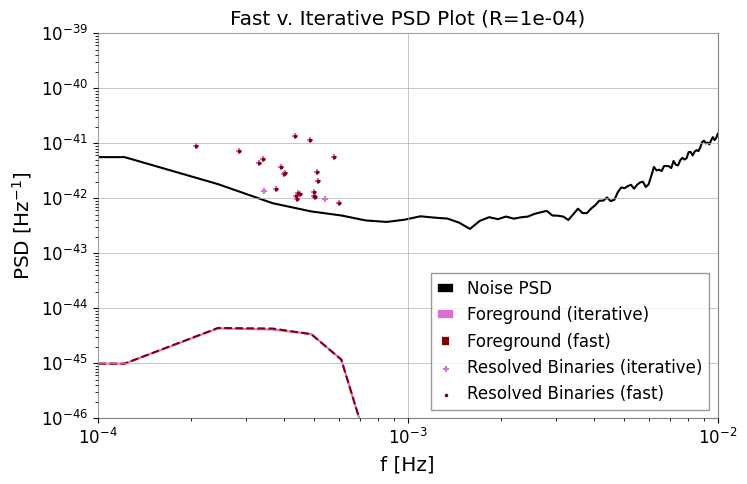

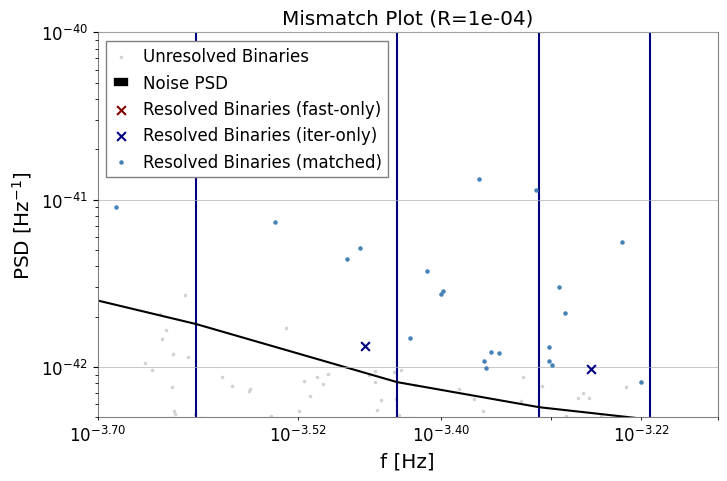

R_LISA = 5e-04
N resolved: 126
N resolved: 146
N resolved: 147
N resolved: 147
Iterative subtraction has converged, stopping after 4 iterations.
Final number of resolved binaries is 147. This is 0.10% of the total catalogue.
Fast N_resolved=138; iterative N_resolved=147.
0 binaries were found by the fast method, but not the iterative method.
9 binaries were found by the iterative method, but not the fast method.
138 binaries were found by both methods.


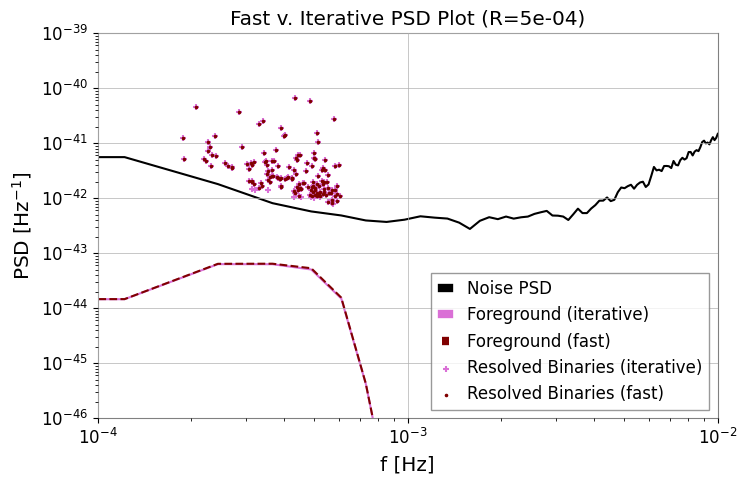

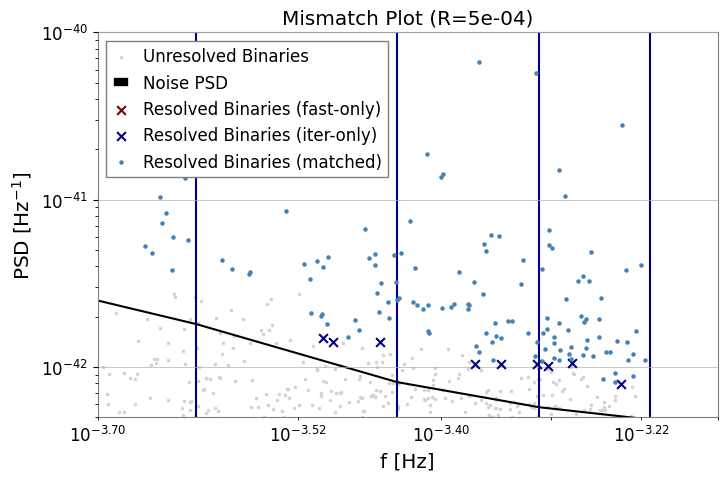

R_LISA = 1e-03
N resolved: 170
N resolved: 244
N resolved: 272
N resolved: 281
N resolved: 281
Iterative subtraction has converged, stopping after 5 iterations.
Final number of resolved binaries is 281. This is 0.19% of the total catalogue.
Fast N_resolved=276; iterative N_resolved=281.
1 binaries were found by the fast method, but not the iterative method.
6 binaries were found by the iterative method, but not the fast method.
275 binaries were found by both methods.


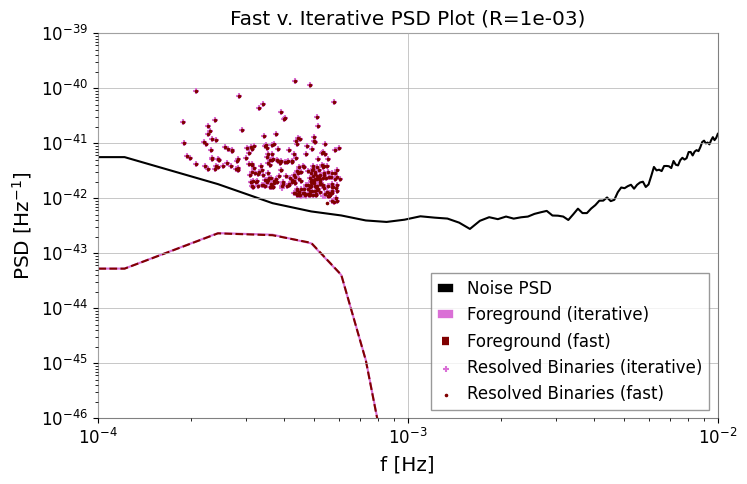

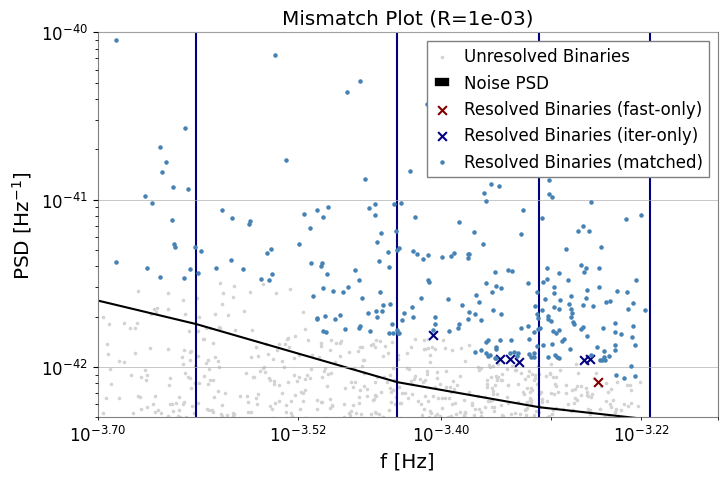

R_LISA = 5e-03
N resolved: 73
N resolved: 183
N resolved: 219
N resolved: 228
N resolved: 235
N resolved: 236
N resolved: 236
Iterative subtraction has converged, stopping after 7 iterations.
Final number of resolved binaries is 236. This is 0.16% of the total catalogue.
Fast N_resolved=1063; iterative N_resolved=236.
827 binaries were found by the fast method, but not the iterative method.
0 binaries were found by the iterative method, but not the fast method.
236 binaries were found by both methods.


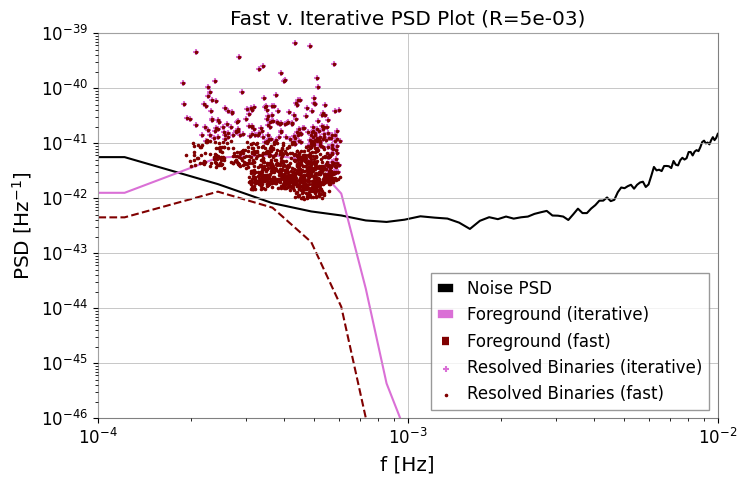

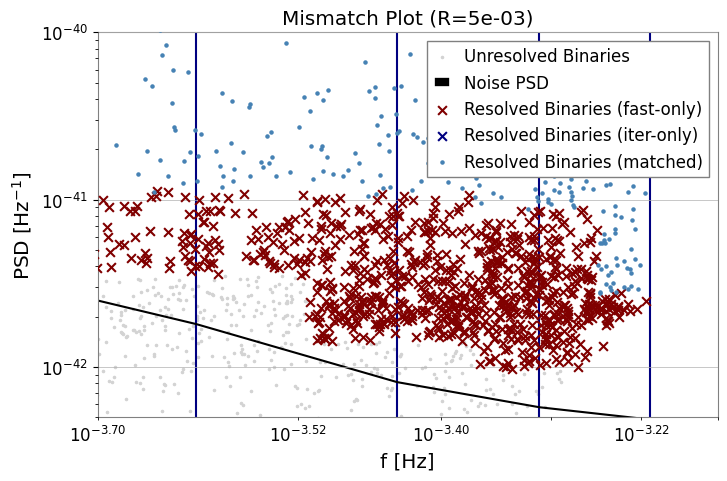

R_LISA = 1e-02
N resolved: 32
N resolved: 69
N resolved: 91
N resolved: 92
N resolved: 92
Iterative subtraction has converged, stopping after 5 iterations.
Final number of resolved binaries is 92. This is 0.06% of the total catalogue.
Fast N_resolved=1326; iterative N_resolved=92.
1234 binaries were found by the fast method, but not the iterative method.
0 binaries were found by the iterative method, but not the fast method.
92 binaries were found by both methods.


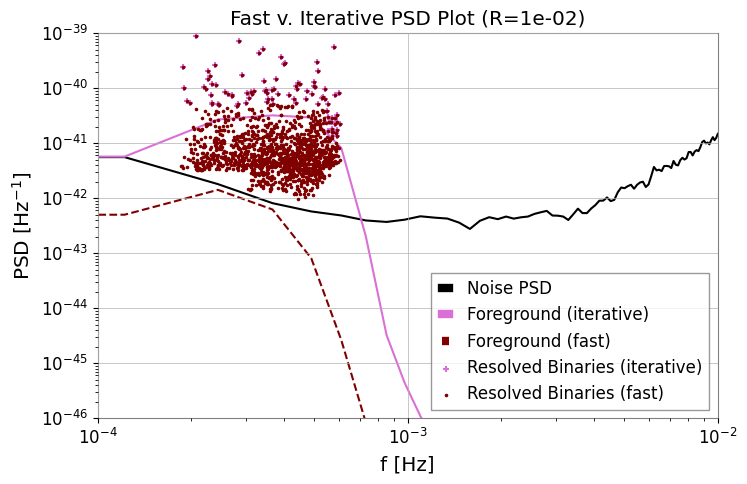

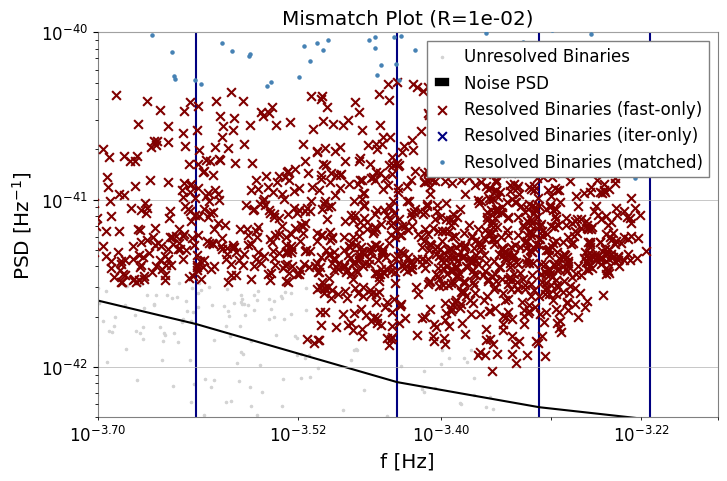

In [56]:
result_dict = {}
for R_i in r_list:
    name_i = '{:0.0e}'.format(R_i)
    print("R_LISA = "+name_i)
    result_dict[name_i] = {}
    
    ## make savedir
    figpath_i = './figures/R'+name_i+'/'
    if not os.path.exists(figpath_i):
        os.mkdir(figpath_i)
    
    popstrains_i = R_i*popstrains_original
    ## full time series
    times_full_i = poptimes
    hoft_full_i = np.sum(popstrains_i.T,axis=0) + noise_dict["timeseries"][0]
#     fs_full_i, fullwelch_i = scipy.signal.welch(hoft_full_i,fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)
    
    ## get iterative result
    res_idx_i, unres_idx_i, res_snrs_i, unres_snrs_i = run_iterative_subtraction(times_full_i,
                                                                                 hoft_full_i,
                                                                                 popstrains_i,
                                                                                 R_i,
                                                                                 N_iter=15)
    ## get iter info for plots
    fw_unresolved_i, welch_unresolved_i = scipy.signal.welch(np.sum(popstrains_i[:,unres_idx_i],axis=1),
                                               fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)
    fs_resolved_i = np.array(df['frequency'][res_idx_i])
    psds_resolved_i = 0.5*R_i*(fw_unresolved_i[1]-fw_unresolved_i[0])**-1 *np.array(df['amplitude'][res_idx_i])**2
    
    ## add to dict
    result_dict[name_i]['iterative'] = {'N_res':len(res_idx_i),
                                        'res_idx':res_idx_i,
                                        'unres_idx':unres_idx_i,
                                        'res_snrs':res_snrs_i,
                                        'unres_snrs':unres_snrs_i,
                                        'fw_unres':fw_unresolved_i,
                                        'welch_unres':welch_unresolved_i,
                                        'fs_res':fs_resolved_i,
                                        'psds_res':psds_resolved_i
                                        }
    
    ## get fast result
    fg_fast_i, N_res_fast_i, res_idx_fast_i, unres_idx_fast_i = bin_sort_threshold(df,
                                                                                   fw_noise,welch_noise_psd,dur_noise,
                                                                                   R_i,wts=1,snr_thresh=7)
    ## make a welched foreground to check amplitudes
    fw_unresolved_fast_i, welch_unresolved_fast_i = scipy.signal.welch(np.sum(popstrains_i[:,unres_idx_fast_i],axis=1),
                                                                       fs=1/dt,window='hann',
                                                                       noverlap=0.0,nperseg=256*8)
    ## get psds for various binaries
    fs_resolved_fast_i = np.array(df['frequency'][res_idx_fast_i])
    psds_resolved_fast_i = 0.5*R_i*(fw_unresolved_fast_i[1]-fw_unresolved_fast_i[0])**-1 \
                                                    *np.array(df['amplitude'][res_idx_fast_i])**2
    ## cross-match
    matched_idx_i = np.unique(np.append(res_idx_i,res_idx_fast_i))
    iter_only_i = matched_idx_i[np.isin(matched_idx_i,res_idx_fast_i,invert=True)]
    fast_only_i = matched_idx_i[np.isin(matched_idx_i,res_idx_i,invert=True)]
    
    fs_resolved_mismatch_fonly_i = fs_resolved_fast_i[np.isin(res_idx_fast_i,res_idx_i,invert=True)]
    psds_resolved_mismatch_fonly_i = psds_resolved_fast_i[np.isin(res_idx_fast_i,res_idx_i,invert=True)]
    fs_resolved_mismatch_ionly_i = fs_resolved_i[np.isin(res_idx_i,res_idx_fast_i,invert=True)]
    psds_resolved_mismatch_ionly_i = psds_resolved_i[np.isin(res_idx_i,res_idx_fast_i,invert=True)]
    
    fs_resolved_match_i = fs_resolved_fast_i[np.isin(res_idx_fast_i,res_idx_i,invert=False)]
    psds_resolved_match_i = psds_resolved_fast_i[np.isin(res_idx_fast_i,res_idx_i,invert=False)]
    
    ## unresolved
    fs_unresolved_fast_i = np.array(df['frequency'][unres_idx_fast_i])
    psds_unresolved_fast_i = 0.5*R_i*(fw_unresolved_fast_i[1]-fw_unresolved_fast_i[0])**-1 *\
                                            np.array(df['amplitude'][unres_idx_fast_i])**2
    
    ## add to dict
    result_dict[name_i]['fast'] =  {'N_res':N_res_fast_i,
                                    'res_idx':res_idx_fast_i,
                                    'unres_idx':unres_idx_fast_i,
                                    'fw_unres':fw_unresolved_fast_i,
                                    'welch_unres':welch_unresolved_fast_i,
                                    'fs_res':fs_resolved_fast_i,
                                    'psds_res':psds_resolved_fast_i
                                    }
    result_dict[name_i]['mismatch'] =  {'N_mismatch':len(iter_only_i)+len(fast_only_i),
                                        'N_match':len(fs_resolved_match_i),
                                        'iter_only_idx':iter_only_i,
                                        'fast_only_idx':fast_only_i
                                       }
    print("Fast N_resolved={}; iterative N_resolved={}.".format(N_res_fast_i,len(res_idx_i)))
    print("{} binaries were found by the fast method, but not the iterative method.".format(len(fast_only_i)))
    print("{} binaries were found by the iterative method, but not the fast method.".format(len(iter_only_i)))
    print("{} binaries were found by both methods.".format(len(fs_resolved_match_i)))
    ## plot
    plt.figure(figsize=(8,5))
    plt.loglog(fw_noise, welch_noise_psd,c='k',label='Noise PSD')
    plt.loglog(fw_unresolved_i,welch_unresolved_i,c='orchid',label='Foreground (iterative)')
    plt.loglog(fw_unresolved_fast_i,welch_unresolved_fast_i,c='maroon',ls='--',label='Foreground (fast)')
    plt.scatter(fs_resolved_i,psds_resolved_i,marker='+',s=20,c='orchid',label='Resolved Binaries (iterative)',zorder=10)
    plt.scatter(fs_resolved_fast_i,psds_resolved_fast_i,marker='.',s=10,c='maroon',label='Resolved Binaries (fast)',zorder=10)
    plt.ylim(1e-46,1e-39)
    plt.xlim(1e-4,1e-2)
    plt.xlabel('f [Hz]')
    plt.ylabel('PSD [Hz$^{-1}$]')
    plt.legend()#loc='lower right')
    plt.title("Fast v. Iterative PSD Plot (R={})".format(name_i))
    for ext in ['.png','.pdf']:
        plt.savefig(figpath_i+'fast_v_iter_psd'+ext)
    plt.show()
    
    plt.figure(figsize=(8,5))
    deltaf = fw_noise[1]-fw_noise[0]
    for i in range(len(fw_noise)):
        plt.axvline(fw_noise[i]+deltaf,c='navy',label='__nolabel__')
    ## add all the unresolved systems
    plt.scatter(fs_unresolved_fast_i,psds_unresolved_fast_i,
                marker='.',s=10,c='lightgrey',label='Unresolved Binaries')#),zorder=10)
    plt.loglog(fw_noise, welch_noise_psd,c='k',label='Noise PSD')
    # plt.loglog(fw_unresolved,welch_unresolved,c='orchid',label='Foreground (iterative)')
    # plt.loglog(fw_unresolved_fast,welch_unresolved_fast,c='maroon',ls='--',label='Foreground (fast)')
    plt.scatter(fs_resolved_mismatch_fonly_i,psds_resolved_mismatch_fonly_i,
                marker='x',s=40,c='maroon',label='Resolved Binaries (fast-only)',zorder=10)
    plt.scatter(fs_resolved_mismatch_ionly_i,psds_resolved_mismatch_ionly_i,
                marker='x',s=40,c='navy',label='Resolved Binaries (iter-only)',zorder=10)
    plt.scatter(fs_resolved_match_i,psds_resolved_match_i,
                marker='.',s=20,c='steelblue',label='Resolved Binaries (matched)',zorder=10)
    plt.ylim(5e-43,1e-40)
    plt.xlim(2e-4,7e-4)
    plt.xlabel('f [Hz]')
    plt.ylabel('PSD [Hz$^{-1}$]')
    plt.legend(framealpha=1).set_zorder(20)#loc='lower right')
    plt.title("Mismatch Plot (R={})".format(name_i))
    for ext in ['.png','.pdf']:
        plt.savefig(figpath_i+'fast_method_mismatch'+ext)
    plt.show()

Hmm... the fast method breaks down when the level of the confusion noise becomes comparable to the level of the instrumental noise. This could be because we are not correctly treating the confusion noise, or because the simulated data we are using (with very few binaries, relatively speaking) is violating the assumptions we are making. Let's investigate:

In [376]:
def calc_naive_Nij(A, noisePSD, wts, duration):
    return np.sqrt(duration*A**2/((noisePSD)))

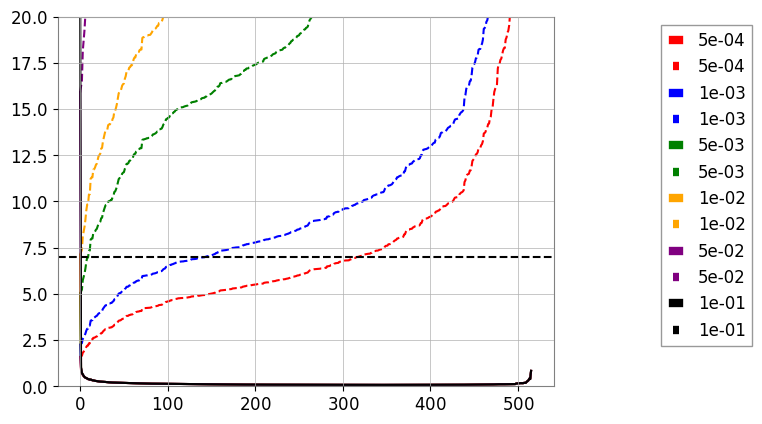

In [377]:
plt.figure()
for rval, col in zip([5e-4,1e-3,5e-3,1e-2,5e-2,1e-1],['red','blue','green','orange','purple','black']):
    filt = np.digitize(np.array(df['frequency']),fw_noise+0.5*(fw_noise[1] - fw_noise[0]))
    fbin_mask = np.array(filt == 3)
    fbin_amps = np.array(df['amplitude'])[fbin_mask]*np.sqrt(rval) ## sqrt because we square the amplitudes to get Sgw
    fbin_sort = np.argsort(fbin_amps)
    re_sort = np.argsort(fbin_sort) ## this will allow us to later return to the original order
    plt.plot(calc_Nij(fbin_amps[fbin_sort],welch_noise_psd[3],1,dur_noise),
             c=col,
             label="{:0.0e}".format(rval))
    plt.plot(calc_naive_Nij(fbin_amps[fbin_sort],welch_noise_psd[3],1,dur_noise),
             ls='--',
             c=col,
             label="{:0.0e}".format(rval))

plt.axhline(7,ls='--',c='k')
plt.legend(bbox_to_anchor=(1.2,1.0))
# plt.xlim(450,510)
plt.ylim(0,20)
plt.show()

This looks promising for the latter explanation. For the values of $R_{LISA}$ that behaved similarly to the iterative method, we have lots of DWDs in the confusion noise; for those that began to diverge, we have very few. It's not computationally feasible to continue to try the iterative method for very large $N_{DWD}$, but we can look at how the fast method would behave with more systems:

In [127]:
np.log10(np.array(df['amplitude'])).min(),np.log10(np.array(df['amplitude'])).max()

(np.float64(-22.027759302051788), np.float64(-20.243162485868787))

In [383]:
np.argmin(np.abs(fs_fullres -fw_noise[3] ))

np.int64(182)

In [ ]:
plt.scatter()

In [ ]:
np.log

In [407]:
## need to average over frequency bins with resolution 1/Tobs to a coarser frequency resolution
## otherwise the assumption of stochasticity breaks down for the population model 
## PSD_rebinned_j = (1/N_bins_summed) * sum_i(PSD_i) for bin_i within coarser bin_j
## where N_bins_summed = delf_new/delf_old = delf_new*Tobs
fw_noise[1]-fw_noise[0]

np.float64(0.00012206933593749999)

In [426]:
## from foreground.py
def calc_Nij_rebinned(A, noisePSD, wts, duration,N_bins_summed):
    '''
    Make the per-frequency SNR vector (dim 1xN_dwd)
    
    Arguments
    ------------
    A (float array)      : Sorted (ascending) DWD amplitudes
    noisePSD (float)     : Level of the noise PSD in the relevant frequency bin (i.e., S_n(f))
    wts (float or array) : weights from fiducial population (1 for now)
    '''
#     np.sqrt(dur_noise*np.array(df['amplitude'])[current_unres_idx]**2 / (4*current_latf))
    print(noisePSD)
    print((1/N_bins_summed)*duration * (np.cumsum(wts*A**2) - wts*A**2) )
    return np.sqrt(duration*A**2/((noisePSD + (1/N_bins_summed)*duration * (np.cumsum(wts*A**2) - wts*A**2) )))
#     return A / (noisePSD + np.cumsum(wts*A))

8.860776822754538e-43
[0.00000000e+00 2.22285680e-51 5.24671076e-51 ... 3.13012892e-42
 3.17151500e-42 3.24983437e-42]


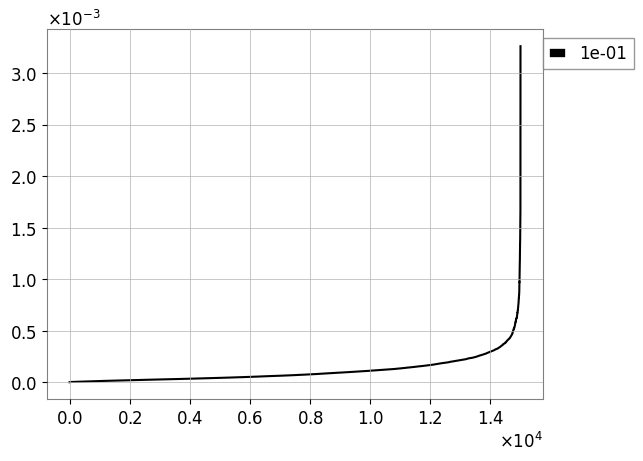

In [439]:
rng = np.random.default_rng(170817)
# spoof_a_low = 10**rng.uniform(-26,-18,size=1000*len(np.array(df['frequency'])))
spoof_a_low = 10**rng.normal(-28.5,0.5,size=10*len(np.array(df['frequency'])))
spoof_f = 10**rng.uniform(np.log10(2e-4),np.log10(6e-4),size=10*len(np.array(df['frequency'])))
# spoof_a = np.append(spoof_a_low,np.array(df['amplitude']))
spoof_a = spoof_a_low
test_dur = 3e7
test_delf = 1/test_dur
N_bins_summed = test_delf/(fw_noise[1]-fw_noise[0])
# fs_longtime = np.arange(1e-4,1e-2,test_delf)
# nidx = np.argmin(np.abs(fs_longtime -fw_noise[3] ))
plt.figure()
# for rval, col in zip([5e-4,1e-3,5e-3,1e-2,5e-2,1e-1],['red','blue','green','orange','purple','black']):
# for rval, col in zip([1e-5,5e-5,1e-4,5e-4,1e-3,3/20],['red','blue','green','orange','purple','black']):
for rval, col in zip([3/20],['black']):
    filt = np.digitize(spoof_f,fw_noise+0.5*(fw_noise[1]-fw_noise[0]))
    fbin_mask = np.array(filt == 3)
    fbin_amps = spoof_a*np.sqrt(rval) ## sqrt because we square the amplitudes to get Sgw
    fbin_sort = np.argsort(fbin_amps)
    re_sort = np.argsort(fbin_sort) ## this will allow us to later return to the original order
    plt.plot(calc_Nij_rebinned(fbin_amps[fbin_sort],welch_noise_psd[3],1,test_dur,N_bins_summed),
             c=col,
             label="{:0.0e}".format(rval))
#     plt.plot(calc_naive_Nij(fbin_amps[fbin_sort],welch_noise_psd[3],1,dur_noise),
#              ls='--',
#              c=col,
#              label="{:0.0e}".format(rval))
# fbin_Nij = calc_Nij(fbin_amps_i[fbin_sort_i],noisePSD[noise_f_idx[i]],wts,duration)
# plt.axhline(7,ls='--',c='k')
plt.legend(bbox_to_anchor=(1.2,1.0))
# plt.yscale('log')
# plt.xlim(3000,5060)
# plt.ylim(0,20)
plt.show()

(array([0., 0., 0., ..., 0., 0., 0.], shape=(49500,)),
 array([0.0001001, 0.0001003, 0.0001005, ..., 0.0099997,
        0.0099999, 0.0100001], shape=(49501,)),
 <BarContainer object of 49500 artists>)

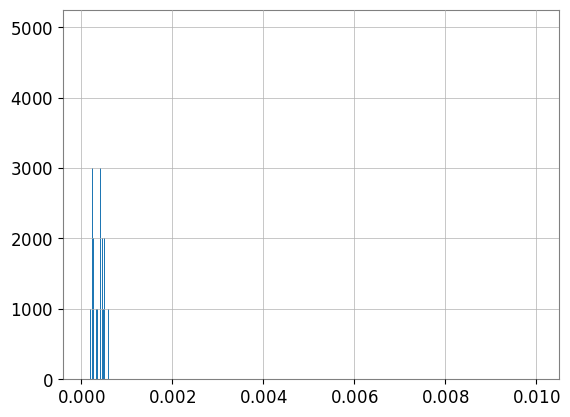

In [398]:
plt.hist(spoof_f,fs_longtime+0.5*test_delf)

In [394]:
calc_Nij(fbin_amps[fbin_sort],welch_noise_psd[3],1,test_dur)

array([], dtype=float64)

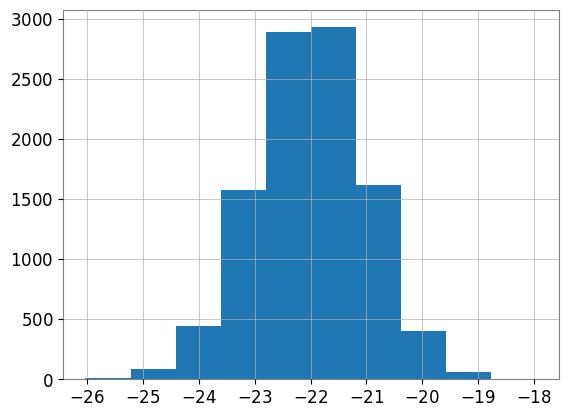

In [136]:
plt.figure()
plt.hist(rng.normal(-22,1,10000))
plt.show()

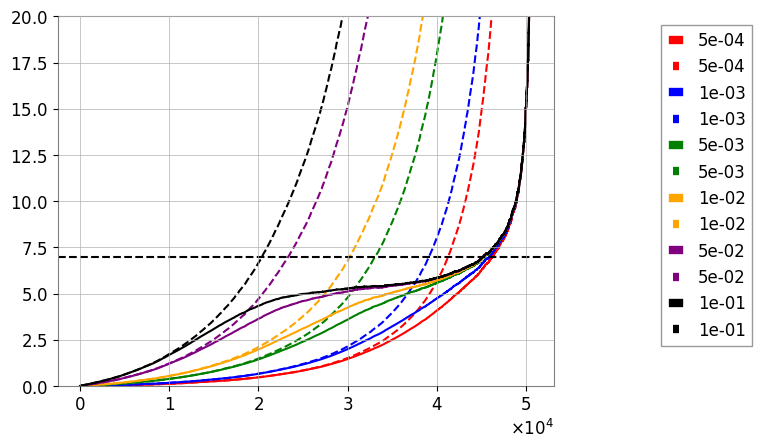

In [143]:
rng = np.random.default_rng(170817)
spoof_a_low = 10**rng.normal(-22,1,size=100*len(np.array(df['frequency'])))
spoof_f = np.repeat(np.array(df['frequency']),100)
# spoof_a = np.append(spoof_a_low,np.array(df['amplitude']))
spoof_a = spoof_a_low
plt.figure()
for rval, col in zip([5e-4,1e-3,5e-3,1e-2,5e-2,1e-1],['red','blue','green','orange','purple','black']):
    filt = np.digitize(spoof_f,fw_noise+0.5*(fw_noise[1] - fw_noise[0]))
    fbin_mask = np.array(filt == 3)
    fbin_amps = spoof_a[fbin_mask]*np.sqrt(rval) ## sqrt because we square the amplitudes to get Sgw
    fbin_sort = np.argsort(fbin_amps)
    re_sort = np.argsort(fbin_sort) ## this will allow us to later return to the original order
    plt.plot(calc_Nij(fbin_amps[fbin_sort],welch_noise_psd[3],1,dur_noise),
             c=col,
             label="{:0.0e}".format(rval))
    plt.plot(calc_naive_Nij(fbin_amps[fbin_sort],welch_noise_psd[3],1,dur_noise),
             ls='--',
             c=col,
             label="{:0.0e}".format(rval))

plt.axhline(7,ls='--',c='k')
plt.legend(bbox_to_anchor=(1.2,1.0))
# plt.xlim(3000,5060)
plt.ylim(0,20)
plt.show()

Okay. I think I've convinced myself that this behaves how it should. I don't think I can actually directly compare the signal-saturated case with the iterative approach unless I completely rewrite it to generate waveforms on the fly instead of doing massive array operations. But let's generate some more-realistic data and see if we get what we expect!

In [171]:
limits = {'chirp_mass':          [0.5, 1.1],  # In solar masses
#           'seperation':          [0.5, 25.0],   # In 1e8 meters
          'seperation':          [5.0, 10.0],   # In 1e8 meters
          'luminosity_distance': [1.0, 50.0],     # In kilo parsecs
          'phase':               [0, 2*np.pi]}
## Instantiate the population distribution object
N_dwd = int(1e6)
dist = PowerLawChirpPowerLawSeperation(limits=limits, 
                                       distance_power_law_index=1,   # p(d) ~ d
                                       N_white_dwarfs=N_dwd,
                                       duration = dur_noise,
                                       sample_rate = 1/dt_noise,
                                       poisson=True) 			     # Total Number of sources should be drawn from poisson distribution

Lambda = {'alpha' : 4.0, 'beta' : -2.0}
# popdict = dist.waveform.compute_waveform_parameters(dist.generate_samples(Lambda, size=N_dwd))
poptimes, popstrains = dist.generate_time_series(Lambda,summed=True)
popdict = dist.samples_from_population
popstrains_original = popstrains
df = pd.DataFrame(popdict)

Generating waveforms...


100%|████████████████████████████████████████████████████████████████████████| 1000545/1000545 [29:23<00:00, 567.43it/s]


In [172]:
def quick_waveforms(ts,A,f,phase,summed=True):
    print("Generating waveforms...")
    if all(isinstance(variable, float) for variable in (A,f,phase)):
        timeseries = A * np.sin((2 * np.pi * f * ts) + phase)
    else:
        if summed:
            timeseries = np.zeros(len(ts))
            for i in tqdm(range(len(A))):
                timeseries += A[i] * np.sin((2 * np.pi * f[i] * ts) + phase[i])
        else:
            timeseries = A * np.sin((2 * np.pi * f * ts[:,None]) + phase)

    return ts, timeseries

In [175]:
r_list2 = [1e-4,3e-4,5e-4,1e-3]#,5e-3,1e-2]

R_LISA = 1e-04
Generating waveforms...


100%|██████████████████████████████████████████████████████████████████████████████| 1189/1189 [00:02<00:00, 536.75it/s]


Fast N_resolved=1189.


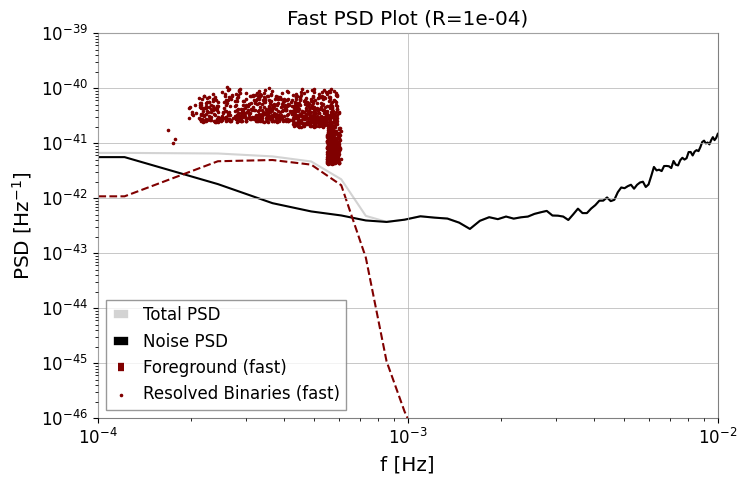

R_LISA = 3e-04
Generating waveforms...


100%|██████████████████████████████████████████████████████████████████████████████| 1326/1326 [00:02<00:00, 536.66it/s]


Fast N_resolved=1326.


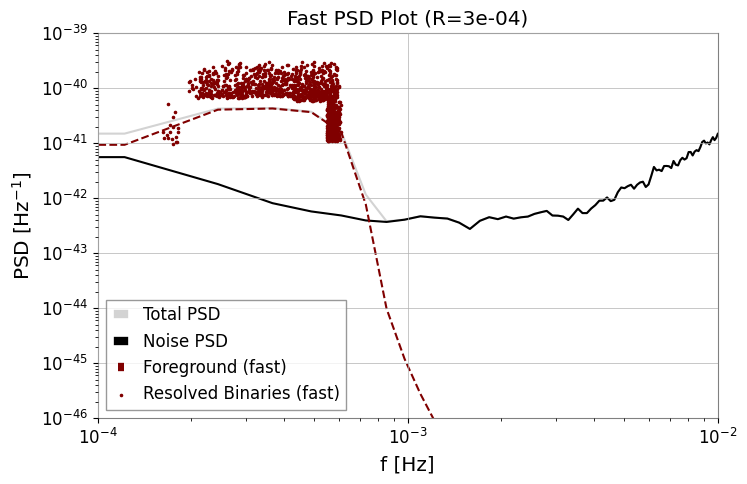

R_LISA = 5e-04
Generating waveforms...


100%|██████████████████████████████████████████████████████████████████████████████| 1385/1385 [00:02<00:00, 537.12it/s]


Fast N_resolved=1385.


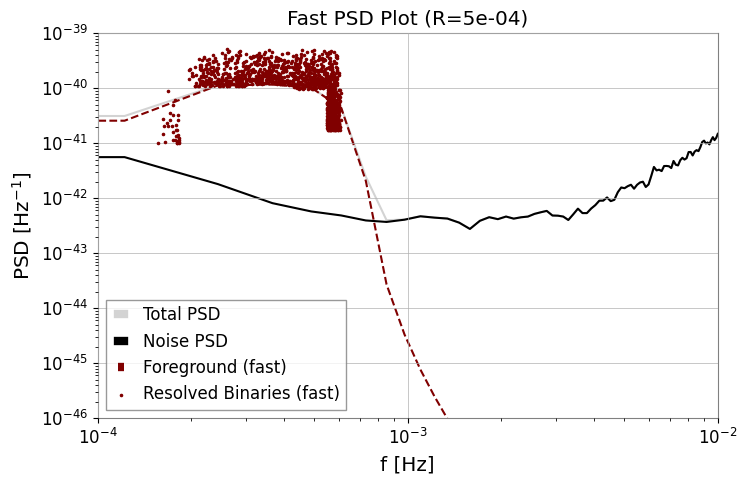

R_LISA = 1e-03
Generating waveforms...


100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:02<00:00, 538.67it/s]


Fast N_resolved=1440.


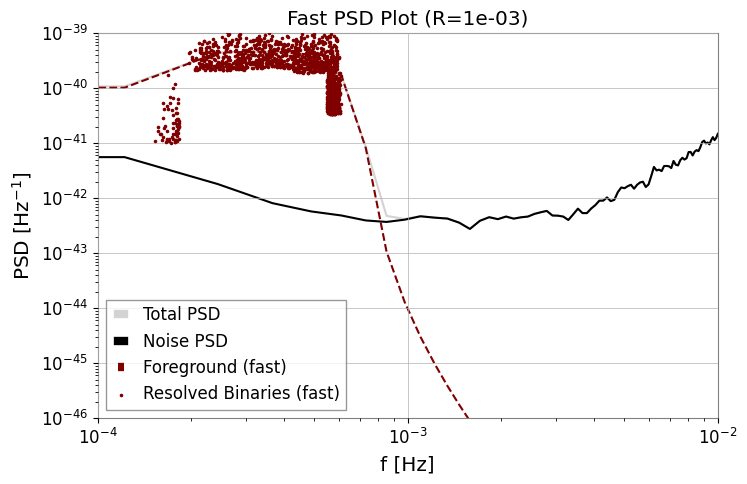

In [177]:
result_dict2 = {}
for R_i in r_list2:
    name_i = '{:0.0e}'.format(R_i)
    print("R_LISA = "+name_i)
    result_dict2[name_i] = {}
    
    ## make savedir
    figpath_i = './figures/fast_only/R'+name_i+'/'
    if not os.path.exists(figpath_i):
        os.makedirs(figpath_i)
    
    popstrains_i = R_i*popstrains_original
    ## full time series
    times_full_i = poptimes
    hoft_full_i = popstrains_i + noise_dict["timeseries"][0]
#     fs_full_i, fullwelch_i = scipy.signal.welch(hoft_full_i,fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)
    
    ## get fast result
    fg_fast_i, N_res_fast_i, res_idx_fast_i, unres_idx_fast_i = bin_sort_threshold(df,
                                                                                   fw_noise,welch_noise_psd,dur_noise,
                                                                                   R_i,wts=1,snr_thresh=7)
    ## make a welched foreground to check amplitudes
    ## need to re-generate the resolved signals
    ts, popstrains_res = quick_waveforms(times_full_i,
                                         np.array(df['amplitude'])[res_idx_fast_i],
                                         np.array(df['frequency'])[res_idx_fast_i],
                                         np.array(df['phase'])[res_idx_fast_i])
    popstrains_unres_i = popstrains_i - R_i*popstrains_res
    fw_unresolved_fast_i, welch_unresolved_fast_i = scipy.signal.welch(popstrains_unres_i,
                                                                       fs=1/dt,window='hann',
                                                                       noverlap=0.0,nperseg=256*8)
    ## get psds for various binaries
    fs_resolved_fast_i = np.array(df['frequency'][res_idx_fast_i])
    psds_resolved_fast_i = 0.5*R_i*(fw_unresolved_fast_i[1]-fw_unresolved_fast_i[0])**-1 \
                                                    *np.array(df['amplitude'][res_idx_fast_i])**2
    ## unresolved
    fs_unresolved_fast_i = np.array(df['frequency'][unres_idx_fast_i])
    psds_unresolved_fast_i = 0.5*R_i*(fw_unresolved_fast_i[1]-fw_unresolved_fast_i[0])**-1 *\
                                            np.array(df['amplitude'][unres_idx_fast_i])**2
    
    ## add to dict
    result_dict2[name_i]['fast'] =  {'N_res':N_res_fast_i,
                                    'res_idx':res_idx_fast_i,
                                    'unres_idx':unres_idx_fast_i,
                                    'fw_unres':fw_unresolved_fast_i,
                                    'welch_unres':welch_unresolved_fast_i,
                                    'fs_res':fs_resolved_fast_i,
                                    'psds_res':psds_resolved_fast_i
                                    }

    print("Fast N_resolved={}.".format(N_res_fast_i))

    ## plot
    plt.figure(figsize=(8,5))
    plt.loglog(fw_noise,welch_noise_psd+welch_unresolved_fast_i,c='lightgrey',label='Total PSD')
    plt.loglog(fw_noise, welch_noise_psd,c='k',label='Noise PSD')
    plt.loglog(fw_unresolved_fast_i,welch_unresolved_fast_i,c='maroon',ls='--',label='Foreground (fast)')
    plt.scatter(fs_resolved_fast_i,psds_resolved_fast_i,marker='.',s=10,c='maroon',label='Resolved Binaries (fast)',zorder=10)
    plt.ylim(1e-46,1e-39)
    plt.xlim(1e-4,1e-2)
    plt.xlabel('f [Hz]')
    plt.ylabel('PSD [Hz$^{-1}$]')
    plt.legend()#loc='lower right')
    plt.title("Fast PSD Plot (R={})".format(name_i))
#     for ext in ['.png','.pdf']:
#         plt.savefig(figpath_i+'fast_psd'+ext)
    plt.show()
    
#     plt.figure(figsize=(8,5))
#     deltaf = fw_noise[1]-fw_noise[0]
#     for i in range(len(fw_noise)):
#         plt.axvline(fw_noise[i]+deltaf,c='navy',label='__nolabel__')
#     ## add all the unresolved systems
#     plt.scatter(fs_unresolved_fast_i,psds_unresolved_fast_i,
#                 marker='.',s=10,c='lightgrey',label='Unresolved Binaries')#),zorder=10)
#     plt.loglog(fw_noise, welch_noise_psd,c='k',label='Noise PSD')
#     plt.scatter(fs_resolved_fast_i,psds_resolved_fast_i,
#                 marker='.',s=10,c='maroon',label='Resolved Binaries',zorder=10)
#     plt.ylim(5e-43,1e-40)
#     plt.xlim(2e-4,7e-4)
#     plt.xlabel('f [Hz]')
#     plt.ylabel('PSD [Hz$^{-1}$]')
#     plt.legend(framealpha=1).set_zorder(20)#loc='lower right')
#     plt.title("Zoom Plot (R={})".format(name_i))
# #     for ext in ['.png','.pdf']:
# #         plt.savefig(figpath_i+'fast_method_zoom'+ext)
#     plt.show()

There is something wonky happening with the welch approximation vs. the resolved binary PSDs. So let's just plot the directly comparable PSD we compute within the fast method:

R_LISA = 1e-06
Fast N_resolved=5.


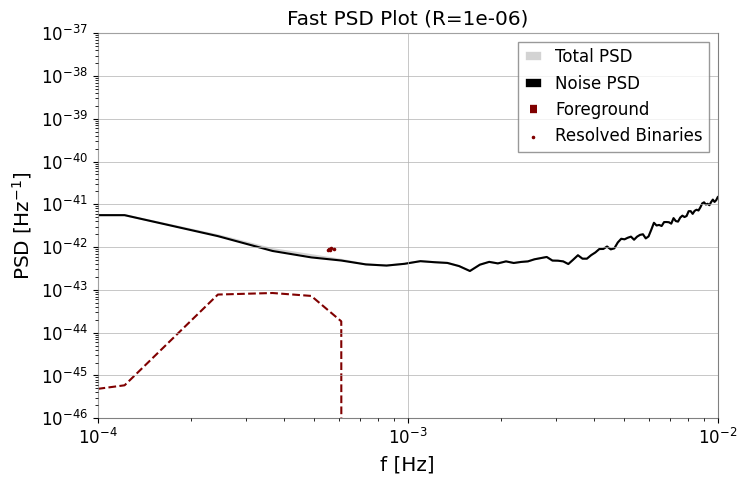

R_LISA = 5e-06
Fast N_resolved=250.


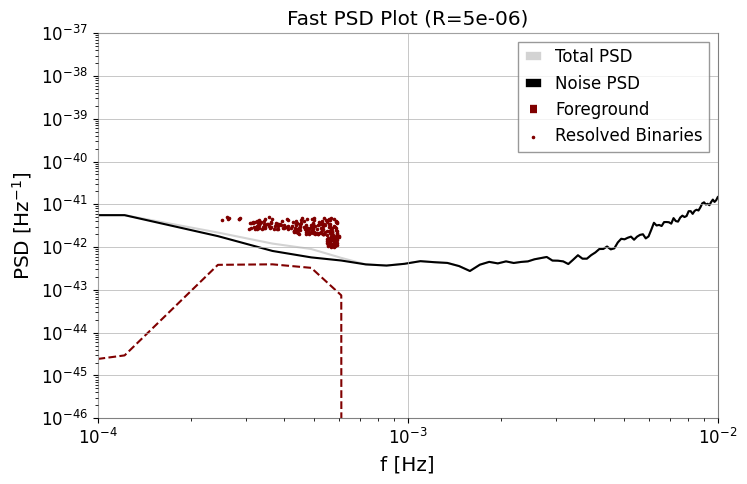

R_LISA = 1e-05
Fast N_resolved=483.


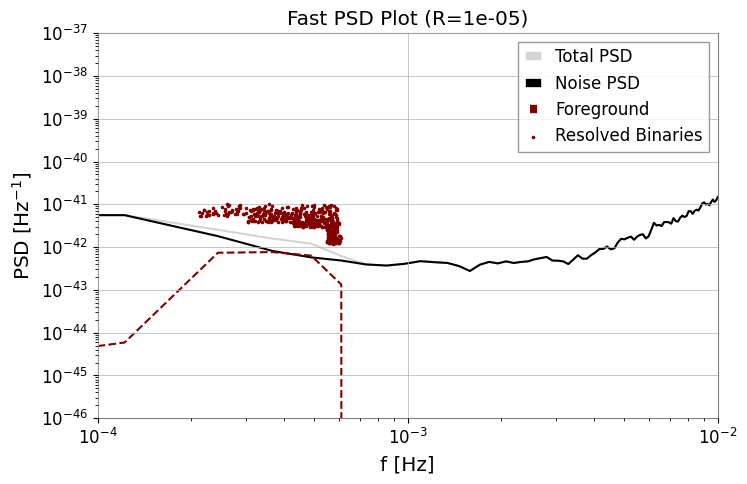

R_LISA = 5e-05
Fast N_resolved=1020.


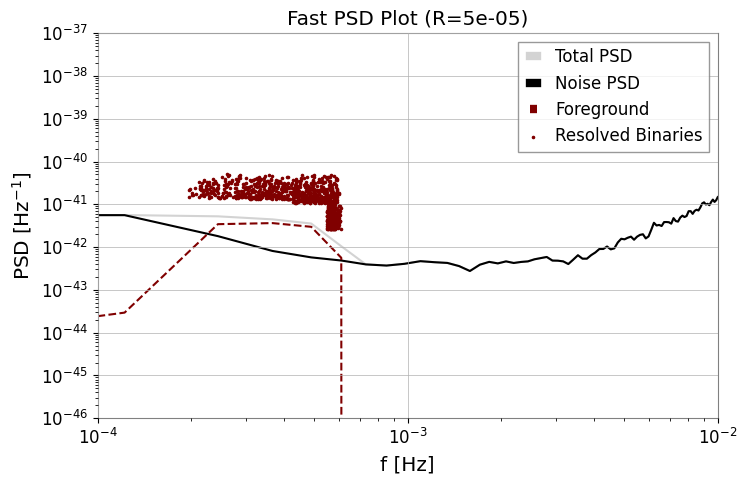

R_LISA = 1e-04
Fast N_resolved=1189.


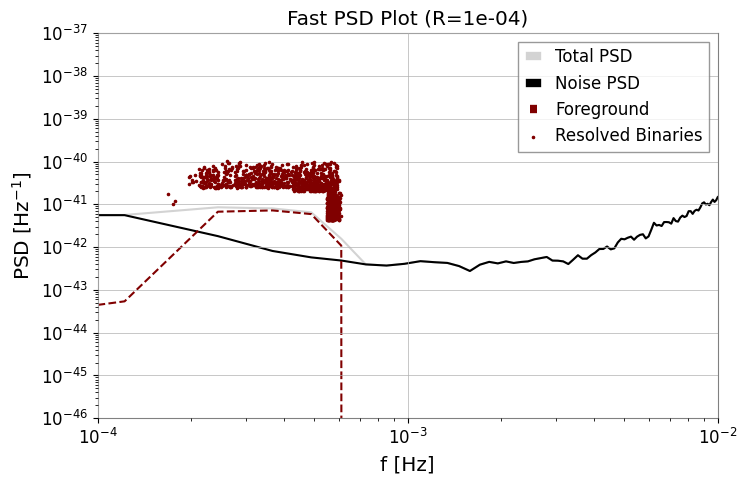

R_LISA = 3e-04
Fast N_resolved=1326.


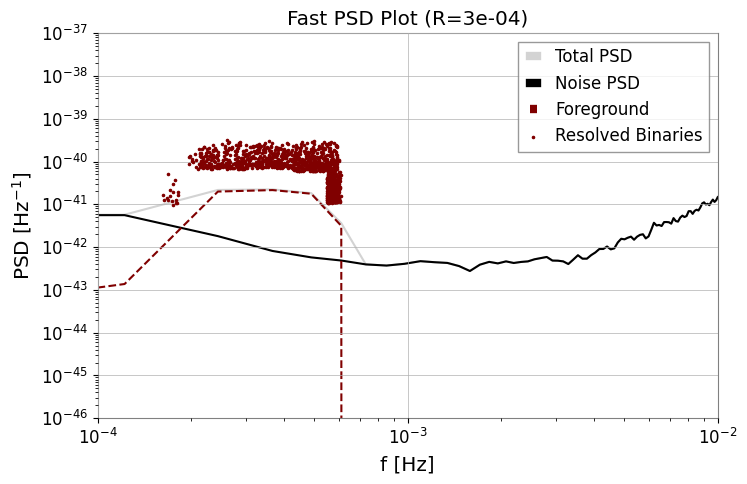

R_LISA = 5e-04
Fast N_resolved=1385.


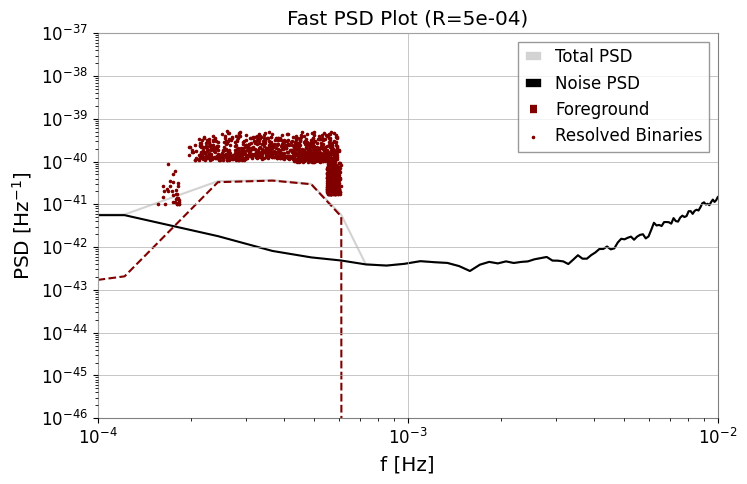

R_LISA = 1e-03
Fast N_resolved=1440.


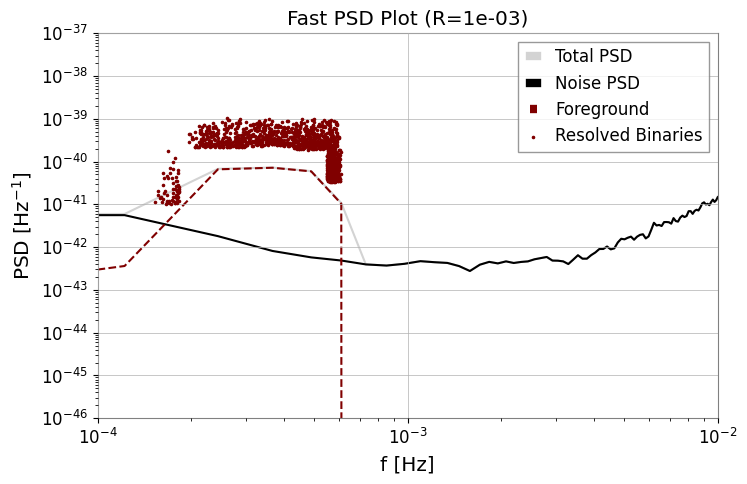

R_LISA = 5e-03
Fast N_resolved=3040.


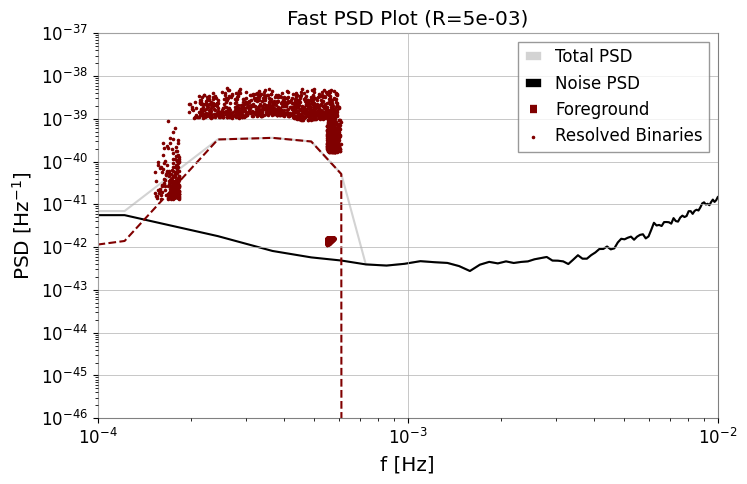

R_LISA = 1e-02
Fast N_resolved=3917.


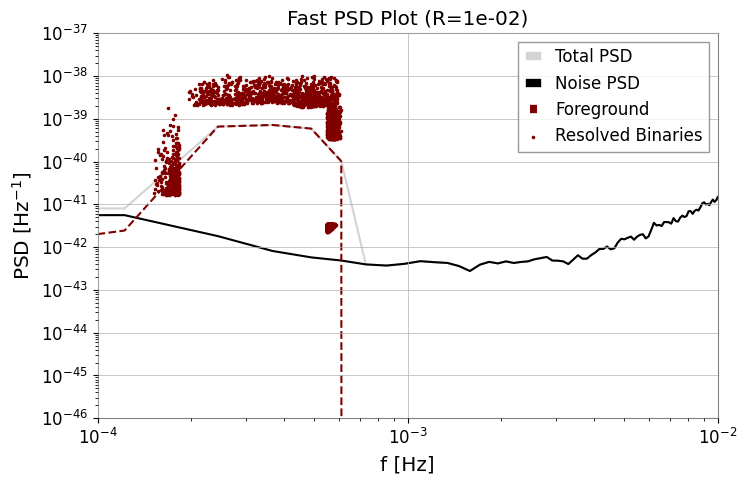

In [197]:
result_dict3 = {}
r_list3 = [1e-6,5e-6,1e-5,5e-5,1e-4,3e-4,5e-4,1e-3,5e-3,1e-2]
for R_i in r_list3:
    name_i = '{:0.0e}'.format(R_i)
    print("R_LISA = "+name_i)
    result_dict3[name_i] = {}
    
#     ## make savedir
#     figpath_i = './figures/fast_only/R'+name_i+'/'
#     if not os.path.exists(figpath_i):
#         os.makedirs(figpath_i)
    
    popstrains_i = R_i*popstrains_original
    ## full time series
    times_full_i = poptimes
    hoft_full_i = popstrains_i + noise_dict["timeseries"][0]
#     fs_full_i, fullwelch_i = scipy.signal.welch(hoft_full_i,fs=1/dt,window='hann',noverlap=0.0,nperseg=256*8)
    
    ## get fast result
    fg_fast_i, N_res_fast_i, res_idx_fast_i, unres_idx_fast_i = bin_sort_threshold(df,
                                                                                   fw_noise,welch_noise_psd,dur_noise,
                                                                                   R_i,wts=1,snr_thresh=7)
    ## make a welched foreground to check amplitudes
    ## need to re-generate the resolved signals
#     ts, popstrains_res = quick_waveforms(times_full_i,
#                                          np.array(df['amplitude'])[res_idx_fast_i],
#                                          np.array(df['frequency'])[res_idx_fast_i],
#                                          np.array(df['phase'])[res_idx_fast_i])
#     popstrains_unres_i = popstrains_i - R_i*popstrains_res
#     fw_unresolved_fast_i, welch_unresolved_fast_i = scipy.signal.welch(popstrains_unres_i,
#                                                                        fs=1/dt,window='hann',
#                                                                        noverlap=0.0,nperseg=256*8)
    ## get psds for various binaries
    fs_resolved_fast_i = np.array(df['frequency'][res_idx_fast_i])
    psds_resolved_fast_i = 0.5*R_i*(fw_unresolved_fast_i[1]-fw_unresolved_fast_i[0])**-1 \
                                                    *np.array(df['amplitude'][res_idx_fast_i])**2
#     psds_resolved_fast_i = 0.5*R_i*dur_noise*np.array(df['amplitude'][res_idx_fast_i])**2
    ## unresolved
#     fs_unresolved_fast_i = np.array(df['frequency'][unres_idx_fast_i])
#     psds_unresolved_fast_i = 0.5*R_i*(fw_unresolved_fast_i[1]-fw_unresolved_fast_i[0])**-1 *\
#                                             np.array(df['amplitude'][unres_idx_fast_i])**2
    
    ## add to dict
    result_dict3[name_i]['fast'] =  {'N_res':N_res_fast_i,
                                    'res_idx':res_idx_fast_i,
                                    'unres_idx':unres_idx_fast_i,
                                    'fw_unres':fw_unresolved_fast_i,
                                    'welch_unres':welch_unresolved_fast_i,
                                    'fs_res':fs_resolved_fast_i,
                                    'psds_res':psds_resolved_fast_i
                                    }

    print("Fast N_resolved={}.".format(N_res_fast_i))

    ## plot
    plt.figure(figsize=(8,5))
    plt.loglog(fw_noise,welch_noise_psd+fg_fast_i,c='lightgrey',label='Total PSD')
    plt.loglog(fw_noise, welch_noise_psd,c='k',label='Noise PSD')
#     plt.loglog(fw_unresolved_fast_i,welch_unresolved_fast_i,c='maroon',ls='--',label='Foreground (fast)')
    plt.loglog(fw_noise,fg_fast_i,c='maroon',ls='--',label='Foreground')
    plt.scatter(fs_resolved_fast_i,psds_resolved_fast_i,marker='.',s=10,c='maroon',label='Resolved Binaries',zorder=10)
    plt.ylim(1e-46,1e-37)
    plt.xlim(1e-4,1e-2)
    plt.xlabel('f [Hz]')
    plt.ylabel('PSD [Hz$^{-1}$]')
    plt.legend()#loc='lower right')
    plt.title("Fast PSD Plot (R={})".format(name_i))
#     for ext in ['.png','.pdf']:
#         plt.savefig(figpath_i+'fast_psd'+ext)
    plt.show()
    
#     plt.figure(figsize=(8,5))
#     deltaf = fw_noise[1]-fw_noise[0]
#     for i in range(len(fw_noise)):
#         plt.axvline(fw_noise[i]+deltaf,c='navy',label='__nolabel__')
#     ## add all the unresolved systems
#     plt.scatter(fs_unresolved_fast_i,psds_unresolved_fast_i,
#                 marker='.',s=10,c='lightgrey',label='Unresolved Binaries')#),zorder=10)
#     plt.loglog(fw_noise, welch_noise_psd,c='k',label='Noise PSD')
#     plt.scatter(fs_resolved_fast_i,psds_resolved_fast_i,
#                 marker='.',s=10,c='maroon',label='Resolved Binaries',zorder=10)
#     plt.ylim(5e-43,1e-40)
#     plt.xlim(2e-4,7e-4)
#     plt.xlabel('f [Hz]')
#     plt.ylabel('PSD [Hz$^{-1}$]')
#     plt.legend(framealpha=1).set_zorder(20)#loc='lower right')
#     plt.title("Zoom Plot (R={})".format(name_i))
# #     for ext in ['.png','.pdf']:
# #         plt.savefig(figpath_i+'fast_method_zoom'+ext)
#     plt.show()

Self-consistent! Woo! Note that the low-amplitude "resolved" signals in the final panel are occuring due to the low-amplitude end of the population in that frequency bin sitting above the noise. This shouldn't happen in a general sense in a realistic case, but we should probably write the final code to avoid this (by e.g., calling all binaries resolved if they are > than the first unresolved signal (counting from the top), as opposed to just applying a mask to the full population.

Note that the binaries that appear below the total noise on the left-hand side are actually not; the noise (incl. the foreground) is binned to the value given to the left of the bin.

It is also worth noting that there is some inconsistency that I haven't figured out between the expression I'm using for the PSD amplitude and the one we get from the Welch approximation. But within a given convention we get consistent results.

In [199]:
result_dict3.keys()

dict_keys(['1e-06', '5e-06', '1e-05', '5e-05', '1e-04', '3e-04', '5e-04', '1e-03', '5e-03', '1e-02'])

We can then look at some of the properties of the resolved binaries:

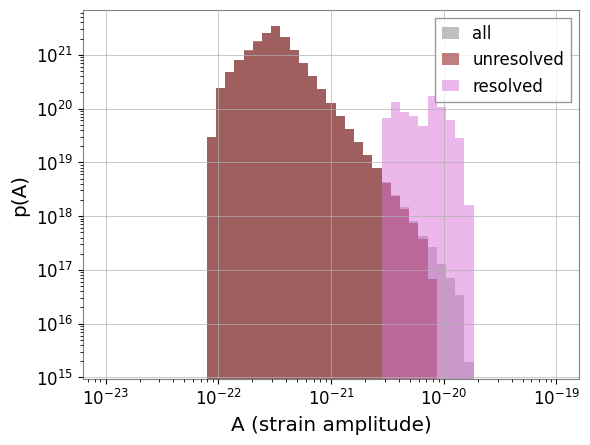

In [215]:
bins = np.logspace(-23,-19,50)
plt.figure()
plt.hist(df['amplitude'],label='all',density=True,bins=bins,alpha=0.5,color='grey')
plt.hist(df['amplitude'][result_dict3['1e-04']['fast']['unres_idx']],
         label='unresolved',density=True,bins=bins,alpha=0.5,color='maroon')
plt.hist(df['amplitude'][result_dict3['1e-04']['fast']['res_idx']],
         label='resolved',density=True,bins=bins,alpha=0.5,color='orchid')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("A (strain amplitude)")
plt.ylabel("p(A)")
# plt.ylim(0,0.5e21)
plt.show()

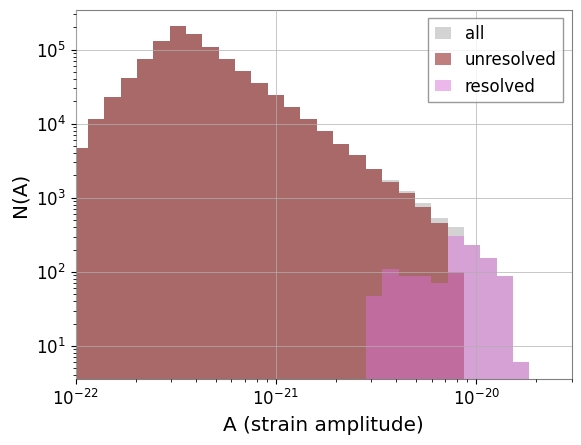

In [220]:
bins = np.logspace(-23,-19,50)
plt.figure()
plt.hist(df['amplitude'],label='all',bins=bins,alpha=0.5,color='darkgrey')
plt.hist(df['amplitude'][result_dict3['1e-04']['fast']['unres_idx']],
         label='unresolved',bins=bins,alpha=0.5,color='maroon')
plt.hist(df['amplitude'][result_dict3['1e-04']['fast']['res_idx']],
         label='resolved',bins=bins,alpha=0.5,color='orchid')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("A (strain amplitude)")
plt.ylabel("N(A)")
# plt.ylim(0,0.5e21)
plt.xlim(1e-22,3e-20)
plt.show()